In [1]:
from password import * #This two line file just defines OCID_username and OCID_password

#For debugging purposes and custom plotting functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%pip install natsort html5_parser
#%matplotlib notebook


online = False
NESTthreads = 72 if online else 16

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Experiment

In [2]:
#Mouse experiment
from package.src.NRP_VC_addon.experiments.Mouse_Experiment.Mouse_Experiment_FORCE_Interpolate import Mouse_Experiment_FORCE_Interpolate

columns = 300
trainP = 8
testP = 8
interP = 8

#speed inter-/extrapolation
frequencies = [1/4,1/2,1]#[1]# #speed interpolat
scenarios=["circle"]
interpolate_fXY=[(1/3,1,1),(1/6,1,1),(4/3,1,1)] #circle frequency interpolate

#pattern extrapolation
#frequencies = [1/2] #gait interpolate
#scenarios=["transversal","longitudinal"]
#interpolate_fXY=[(frequencies[0],1/2,1/2),(frequencies[0],1,1)] # circe 0.5 circle 1

#1 Hz only
#interP = 1
#frequencies = [1]# #speed interpolat
#scenarios=["circle"]
#interpolate_fXY=[(1.0,1,1)] #circle frequency interpolate

# half trans, full circle
#interpolate_fXY contains triplets that describe phases for interpolation phase

saveFile = f"output/p={columns}_f={frequencies}_S={scenarios}_{trainP}_{testP}_{interP}.pkl"
repeatFactor=2


#load existing
import os
import pickle

override = False

if(os.path.exists(saveFile) and override==False):
    with open(saveFile, 'rb') as f:
        exp = pickle.load(f)
    
    loaded = True
    
    print(f"Experiment loaded form {saveFile}")

else:
    loaded = False
    
    exp = Mouse_Experiment_FORCE_Interpolate(
        exp_id="nrpexperiment_robobrain_mouse_v5_0",
        dataDirectory="data/",
        workingFolderDirectory="output/",
        muscleGTdir="data/",
        templateFolder="data/Mouse_Experiment/templates/",
        scenarios=scenarios,
        frequencies=frequencies,
        repeatFactor=repeatFactor, #how often the training sequence made up of the permuatiosn shall be repated (vandesomple default =2) 
        interpolate_fXY=interpolate_fXY,
        brainFileName=None,#"hidden_projectionsx40.txt",
        bibiMode="<mode>SynchronousDirectNestSimulation</mode>", #standard (docker, default online NRP)
        #bibiMode="<mode>SynchronousNestClientSimulation</mode>",#cluster mode
        folderInfix=f"_{scenarios}_{frequencies}_",
        #Phases
        pid_init_duration=0,  # seconds
        pid_movement_duration=2 , # Periods
        FORCE_open_loop_duration=trainP ,#Periods
        FORCE_mixed_duration=trainP ,# Periods
        FORCE_closed_loop_duration=trainP,# Periods
        FORCE_testing_duration=testP, #Periods
        FORCE_interpolation_duration=interP,
        #Brain
        columns=columns, Nexec=30, Ninh=10, #260 is good for my PC, 300 or 400 for bene server
        NESTthreads=NESTthreads,
        noiseSD=1,# gauss noise applied on sensor population. empirically tested based on w magnitude (0.2 to small, 10 to big)
        # 2 und höher machen irgendwie mehr testing error. unter 0.5 wirds auch nicht besser
        # tested auf trans 1
        lamb=6.15, spectralR=4.13,
        feedbackFactor=35.0, #how much the feedback signak is scaled
        # bei den künstlichen ist relativ egal was man nimmt (zwischen 20 und 50), bei real ist 35 gut
        p_shotNoise= 0.01,#0.01,  #probability of spike (impulse noise)
        shotSizeMax = 0.05,  # maximal noise size. so a signal value of 1 gets moved somewhere to [1,1.5] 
        gtNoiseSD = 0.05 # gaussian noise on the GT signal during learning. Note: this noise is scaled by the actual signal size!
        # so 0.05 bis 0.10 sind gut. (circle 1)
    )

Experiment loaded form output/p=300_f=[0.25, 0.5, 1]_S=['circle']_8_8_8.pkl


## Simulation

In [3]:
if(not loaded):

    from package.src.NRP_VC_addon.NRP_Simulator import NRP_Simulator_Local, NRP_Simulator_Online

    if(online):
        simulator = NRP_Simulator_Online(OCID_username=OCID_username,OCID_password=OCID_password, maxTries=1,
                                VC_address="http://148.187.148.14",#bene server
                                VC_TTL=0# muss man immer neu anfordern auf den servern
                                        ) 
    else:
        simulator = NRP_Simulator_Local()

    simulator.setExperiment(exp)
    
    simulator.run()
    
    print("done.")
    
    with open(saveFile, 'wb') as f:
        pickle.dump(exp, f, pickle.HIGHEST_PROTOCOL)
        
else:
    print(f"No simulation necesarry as finished experiment was loaded from {saveFile}")
    
    if(os.path.exists(exp.workingFolder) == False):
        os.mkdir(exp.workingFolder)
        
self = exp #when copying code from the class, its nice to have "self" available
    
    

No simulation necesarry as finished experiment was loaded from output/p=300_f=[0.25, 0.5, 1]_S=['circle']_8_8_8.pkl


In [4]:
#Get all CSV file outputs (for convinience)
FORCE_inputs = exp.resultFiles["CSV"]["FORCE_inputs.csv"]
print(f'FORCE_inputs: {FORCE_inputs.keys()}')
SNN_FORCE = exp.resultFiles["CSV"]["SNN_FORCE.csv"]
print(f'SNN_FORCE: {SNN_FORCE.keys()}')
states = exp.resultFiles["CSV"]["states.csv"]
print(f'states: {states.keys()}')
#muscle_controller = exp.resultFiles["CSV"]["muscle_controller.csv"]
joint_controller = exp.resultFiles["CSV"]["joint_controller.csv"]
print(f'joint_controller: {joint_controller.keys()}')


FORCE_inputs: dict_keys(['time', 'sensor_pop', 'hli_pop', 'runtime', 'Simulation_reset'])
SNN_FORCE: dict_keys(['time', 'sensor_monitor', 'reservoir_state', 'readout', 'output_force', 'new_w', 'error', 'runtime', 'Simulation_reset', 'max_amps', 'error_abs', 'new_w_diff', 'new_w_diff_magnitude', 'new_w_magnitude', 'sensor_monitor_1', 'sensor_monitor_2'])
states: dict_keys(['time', 'muscleStates', 'jointStates', 'runtime', 'Simulation_reset'])
joint_controller: dict_keys(['time', 'runtime', 'Simulation_reset'])


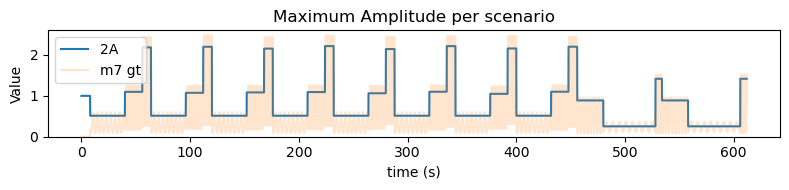

In [5]:
#Maximal Amplitude plot
fig_width = 8
fig_height = 2
nrows = 1
fig, axs = plt.subplots(
            nrows=nrows,
            ncols=1,
            sharey='row', sharex='all',
            figsize=(fig_width,nrows*fig_height),
            squeeze=False)

selectIndices = [7]

for row,m in enumerate(selectIndices):
    axs[row][0].plot(SNN_FORCE["time"],SNN_FORCE["max_amps"][:,m],label="2A")
    axs[row][0].plot(FORCE_inputs["time"],np.array(exp.MuscleValues)[:,m],label=f"m{m} gt",alpha=0.2)

axs[0][0].set_xlabel("time (s)")
axs[0][0].set_ylabel("Value")
axs[0][0].set_title("Maximum Amplitude per scenario")
axs[0][0].legend()
axs[0][0].set_ylim(0,None)
fig.tight_layout()

plt.savefig(exp.workingFolder+"max_amps.svg")
plt.show()


## TF-Runtime Analysis (*Used in Figure 5.8*)

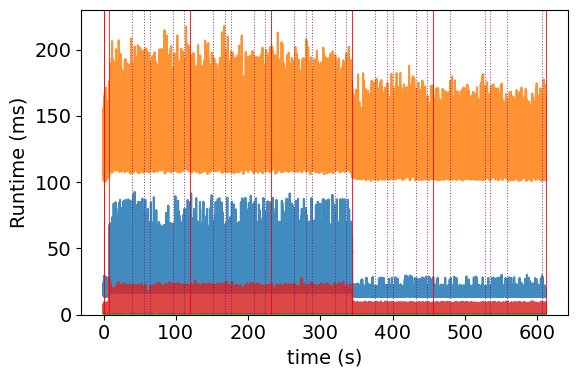

In [6]:
a = 0.85

matplotlib.rcParams.update({'font.size': 14})

fig_width = 6
fig_height = 4
nrows = 1
fig, axs = plt.subplots(
            nrows=nrows,
            ncols=1,
            sharey='row', sharex='all',
            figsize=(fig_width,nrows*fig_height),
            squeeze=False)

selectIndices = [7]
axs[0][0].plot(FORCE_inputs["time"],FORCE_inputs["runtime"],
                 #label="sensor2brain.py",alpha=a)
                 label="FRC_send_sensor2brain.py",alpha=a)
axs[0][0].plot(SNN_FORCE["time"],SNN_FORCE["runtime"],
                 #label="SNN_FORCE.py",alpha=a)
                 label="FRC_tf_SNN_FORCE.py",alpha=a)
axs[0][0].plot(states["time"],states["runtime"],
                 label="csv_recorder.py",alpha=a)
                 #label="csv_recorder.py",alpha=a)
#plt.plot(muscle_controller["time"],muscle_controller["runtime"],label="muscle_controller.py",alpha=a)
axs[0][0].plot(joint_controller["time"],joint_controller["runtime"],
                 label="joint_controller.py",alpha=a)
                 #label="joint_controller.py",alpha=a)

#add phases
pColor = ["red", "purple"] #phase, scenario
pStyle = ["-",":"]
pWidth = [0.75, 0.75]
alpha = [0.75, 0.75]

for phase in exp.phases:
    axs[0][0].axvline(phase["t_start"], color = pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])
    
    if (phase["name"] in ["FORCE open loop","FORCE mixed","FORCE closed loop","FORCE testing"] ):  # -> GT with/without noise
        t_start=phase["t_start"]
        for section in self.subsections:
            duration = phase["periods"]/section["frequency"]
            t_end=t_start+duration
            
            if(phase["t_start"] != t_start):
                axs[0][0].axvline(t_start, color = pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

            t_start = t_end #update temporal position
        if(phase["t_start"] != t_start):
            axs[0][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

    elif (phase["name"] == "FORCE interpolation"):

        t_start=phase["t_start"]
        for section in self.interpolateSubsections:
            duration = phase["periods"]/section["frequency"]
            t_end=t_start+duration
            if(phase["t_start"] != t_start):
                axs[0][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

            t_start = t_end #update temporal position
        if(phase["t_start"] != t_start):
            axs[0][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

    
axs[0][0].axvline(exp.phases[-1]["t_start"]+exp.phases[-1]["duration"], color =  pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])
   
    
axs[0][0].set_ylim(0,230)
axs[-1][0].set_xlabel(f'time (s)')
axs[0][0].set_ylabel(f'Runtime (ms)')
#axs[0][0].legend()
#axs[0][0].set_title("")
fig.tight_layout()

plt.savefig(exp.workingFolder+"runtime.svg")
plt.show()


## Example Movement (*Used in Figure 4.2*) 

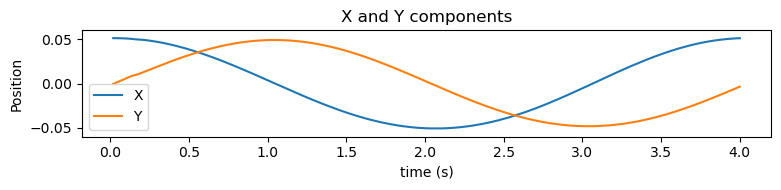

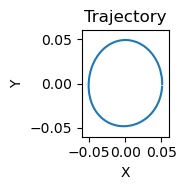

In [7]:
matplotlib.rcParams.update({'font.size': 10})

scenario = "long"
x,y = [],[]
for state in states["jointStates"]:
    X,Y,Z=state["position"]["rel"]
    x.append(X)
    y.append(Y)
d = int(1/(exp.frequency*exp.stepSize))
off = d
fr, to = off, off+d


fig_width = 8
fig_height = 2
ncols= 1
nrows = 1
fig, axs = plt.subplots(
            nrows=nrows,
            ncols=1,
            sharey='row', sharex='all',
            figsize=(fig_width,nrows*fig_height),
            squeeze=False)

selectIndices = [7]
axs[0][0].plot(np.array(states["time"][fr:to])-(off*exp.stepSize),x[fr:to],label="X")
axs[0][0].plot(np.array(states["time"][fr:to])-(off*exp.stepSize),y[fr:to],label="Y")
 
#axs[0][0].set_ylim(0,None)
axs[-1][0].set_xlabel(f'time (s)')
axs[0][0].set_ylabel(f'Position')
axs[0][0].legend()
axs[0][0].set_ylim(-0.06,0.06)
axs[0][0].set_title("X and Y components")
fig.tight_layout()

plt.savefig(exp.workingFolder+f"{scenario}_X_Y_components.svg")
plt.show()

fig_width = 2
fig_height = 2
nrows = 1
fig, axs = plt.subplots(
            nrows=nrows,
            ncols=1,
            sharey='row', sharex='all',
            figsize=(fig_width,nrows*fig_height),
            squeeze=False)

axs[0][0].plot(x[fr:to],y[fr:to])

#axs[0][0].set_ylim(0,None)
axs[-1][0].set_xlabel(f'X')
axs[0][0].set_ylabel(f'Y')
#axs[0][0].legend()
axs[0][0].set_xlim(-0.06,0.06)
axs[0][0].set_ylim(-0.06,0.06)
axs[0][0].set_title("Trajectory")
fig.tight_layout()

plt.savefig(exp.workingFolder+f"{scenario}_trajectory.svg")
plt.show()



## Inputs

In [8]:
FORCE_inputs = exp.resultFiles["CSV"]["FORCE_inputs.csv"]

for i,phase in enumerate(exp.phases):
    print(f'Phase {i} from \t {phase["t_start"]}s \t to \t {phase["t_start"]+phase["duration"]}s\t \"{phase["name"]}\"')

Phase 0 from 	 0s 	 to 	 0s	 "pid init"
Phase 1 from 	 0s 	 to 	 8.0s	 "pid movement"
Phase 2 from 	 8.0s 	 to 	 120.0s	 "FORCE open loop"
Phase 3 from 	 120.0s 	 to 	 232.0s	 "FORCE mixed"
Phase 4 from 	 232.0s 	 to 	 344.0s	 "FORCE closed loop"
Phase 5 from 	 344.0s 	 to 	 456.0s	 "FORCE testing"
Phase 6 from 	 456.0s 	 to 	 612.0s	 "FORCE interpolation"


In [9]:
exp.phases

[{'name': 'pid init', 't_start': 0, 'duration': 0},
 {'name': 'pid movement', 't_start': 0, 'duration': 8.0},
 {'name': 'FORCE open loop', 't_start': 8.0, 'duration': 112.0, 'periods': 8},
 {'name': 'FORCE mixed', 't_start': 120.0, 'duration': 112.0, 'periods': 8},
 {'name': 'FORCE closed loop',
  't_start': 232.0,
  'duration': 112.0,
  'periods': 8},
 {'name': 'FORCE testing', 't_start': 344.0, 'duration': 112.0, 'periods': 8},
 {'name': 'FORCE interpolation',
  't_start': 456.0,
  'duration': 156.0,
  'periods': 8}]

stepLim[0, 400]


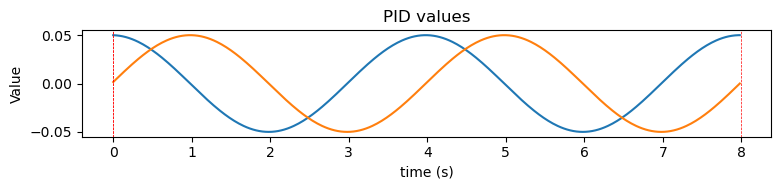

stepLim[0, 30600]


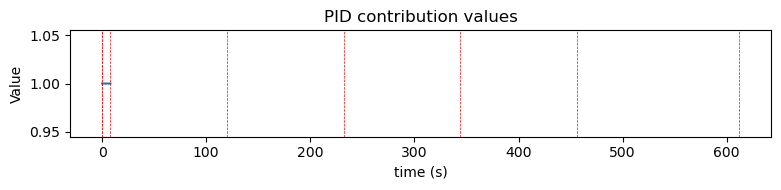

stepLim[0, 30600]


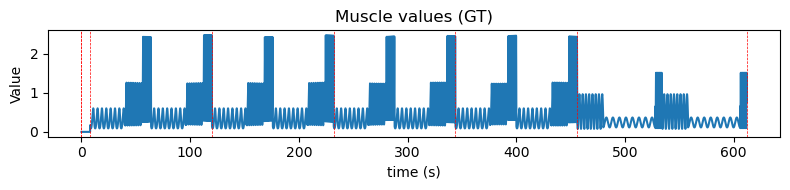

stepLim[6000, 11600]


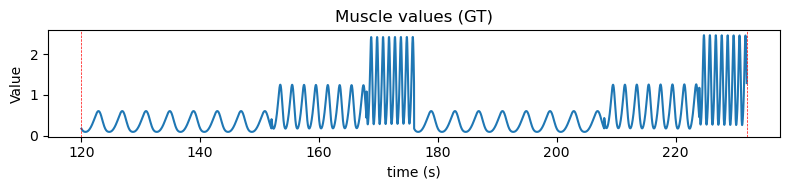

stepLim[0, 30600]


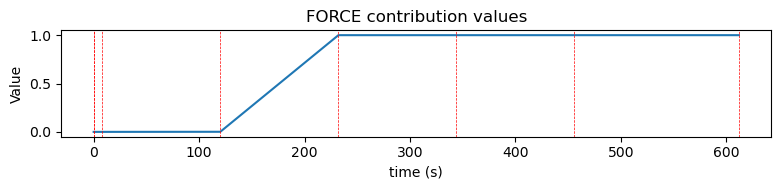

In [10]:
selectIndices = [7]

#draw PID
exp.plotData(
    exp.PIDvalues,
    #valueDict = {"X":[],"Y":[]},
    phaseName="pid movement",
    fig_height=2,
    title = "PID values",
    fileName="PID_Values.svg",
    legend=False)

#draw PID contribution
exp.plotData(
    exp.PIDcontributionValues,
    #valueDict = {"Force Contribution":[]}, title = "Control values",
    title = "PID contribution values",
    fig_height=2,
    flat=True,
    fileName="PID_Contribution_Values.svg",
    legend=False)

#draw Muscle Innervation
exp.plotData(
    exp.MuscleValues,
    #valueDict = {"Foot1":[],"Foot2":[],"Radius1":[],"Radius2":[],"Humerus1":[],"Humerus2":[],"Humerus3":[], "Humerus4":[]},
    selectIndices=selectIndices,
    fig_height=2,
    title = "Muscle values (GT)",
    fileName="GT_Muscle_Values.svg",
    #tlim=(None,20),
    legend=False)

exp.plotData(
    exp.MuscleValues,
    #valueDict = {"Foot1":[],"Foot2":[],"Radius1":[],"Radius2":[],"Humerus1":[],"Humerus2":[],"Humerus3":[], "Humerus4":[]},
    selectIndices=selectIndices,
    fig_height=2,
    title = "Muscle values (GT)",
    phaseName="FORCE mixed",
    fileName="GT_Muscle_Values_mixedPhase.svg",
    #tlim=(None,20),
    legend=False)

#draw Controls
exp.plotData(
    exp.FORCEcontributionValues,
    #valueDict = {"Force Contribution":[]}, title = "Control values",
    flat=True,
    fig_height=2,
    title = "FORCE contribution values",
    legend=False)

## *Used in Figure 5.1* 
Dont forget to change the following lines to remove the sgnal distortion (we used for visualization purposes on the pattern controls):

from
```python3
axs[0][0].plot(ts-0.5,X-0.01,label="X",alpha=1)
axs[0][0].plot(ts+0.5,Y+0.01,label="Y",alpha=1)
```
to 

```python3
axs[0][0].plot(ts,X,label="X",alpha=1)
axs[0][0].plot(ts,Y,label="Y",alpha=1)
```

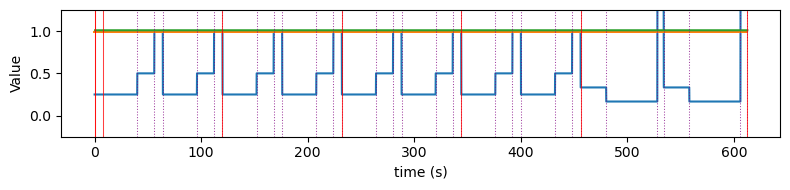

In [11]:

#controls
matplotlib.rcParams.update({'font.size': 10})

f,X,Y = np.array(FORCE_inputs["hli_pop"]).transpose()

fig_width = 8
fig_height = 2
ncols= 1
nrows = 1
fig, axs = plt.subplots(
            nrows=nrows,
            ncols=1,
            sharey='row', sharex='all',
            figsize=(fig_width,nrows*fig_height),
            squeeze=False)



ts = np.array(FORCE_inputs["time"])
axs[0][0].plot(ts,f,label="f",alpha=1)
#axs[0][0].plot(FORCE_inputs["time"],X,label="X",alpha=0.5,color="green",linewidth=6)
#axs[0][0].plot(FORCE_inputs["time"],Y,label="Y",alpha=0.5,color="red",linewidth=3)
axs[0][0].plot(ts-0.5,X-0.01,label="X",alpha=1)
axs[0][0].plot(ts+0.5,Y+0.01,label="Y",alpha=1)


#add phases
pColor = ["red", "purple"] #phase, scenario
pStyle = ["-",":"]
pWidth = [0.75, 0.75]
alpha = [0.75, 0.75]

#add scenario transitions
for phase in exp.phases:
    axs[0][0].axvline(phase["t_start"], color = pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])
    
    if (phase["name"] in ["FORCE open loop","FORCE mixed","FORCE closed loop","FORCE testing"] ):  # -> GT with/without noise
        t_start=phase["t_start"]
        for section in self.subsections:
            duration = phase["periods"]/section["frequency"]
            t_end=t_start+duration
            
            if(phase["t_start"] != t_start):
                axs[0][0].axvline(t_start, color = pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

            t_start = t_end #update temporal position
        if(phase["t_start"] != t_start):
            axs[0][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

    elif (phase["name"] == "FORCE interpolation"):

        t_start=phase["t_start"]
        for section in self.interpolateSubsections:
            duration = phase["periods"]/section["frequency"]
            t_end=t_start+duration
            if(phase["t_start"] != t_start):
                axs[0][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

            t_start = t_end #update temporal position
        if(phase["t_start"] != t_start):
            axs[0][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

    
axs[0][0].axvline(exp.phases[-1]["t_start"]+exp.phases[-1]["duration"], color =  pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])
    
    
#axs[0][0].set_ylim(0,None)
axs[-1][0].set_xlabel(f'time (s)')
axs[0][0].set_ylabel(f'Value')
#axs[0][0].legend()
axs[0][0].set_ylim(-0.25,1.25)
#axs[0][0].set_title("Control Inputs")
fig.tight_layout()

plt.savefig(exp.workingFolder+f"Controls_adv.svg")
plt.show()

## Results

In [12]:
for t in ["CSV","profiler","filesystem"]:
    print("Output type \""+t+"\" files:")
    for filename in exp.resultFiles[t].keys():
        print(f'\t{filename} : {exp.resultFiles[t][filename].keys()}')
    

Output type "CSV" files:
	states.csv : dict_keys(['time', 'muscleStates', 'jointStates', 'runtime', 'Simulation_reset'])
	joint_controller.csv : dict_keys(['time', 'runtime', 'Simulation_reset'])
	FORCE_inputs.csv : dict_keys(['time', 'sensor_pop', 'hli_pop', 'runtime', 'Simulation_reset'])
	SNN_FORCE.csv : dict_keys(['time', 'sensor_monitor', 'reservoir_state', 'readout', 'output_force', 'new_w', 'error', 'runtime', 'Simulation_reset', 'max_amps', 'error_abs', 'new_w_diff', 'new_w_diff_magnitude', 'new_w_magnitude', 'sensor_monitor_1', 'sensor_monitor_2'])
Output type "profiler" files:
Output type "filesystem" files:


In [13]:
#for convinience
FORCE_inputs = exp.resultFiles["CSV"]["FORCE_inputs.csv"]
SNN_FORCE = exp.resultFiles["CSV"]["SNN_FORCE.csv"]
states = exp.resultFiles["CSV"]["states.csv"]

### Trajectory

In [14]:
#prepare data
ts = states["time"]
jointStates = states["jointStates"]
temp = [d["position"]["rel"] for d in jointStates]
x,y,z = np.array(temp).transpose()


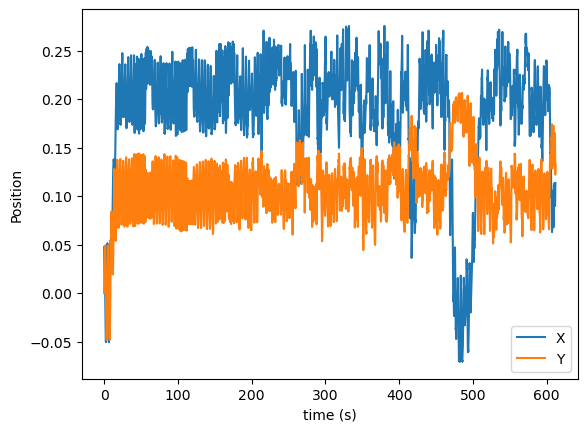

In [15]:
plt.figure()
plt.plot(ts,x,label="X")
plt.plot(ts,y,label="Y")
plt.ylabel("Position") #in absolute pyhsics cooridnates
plt.xlabel("time (s)")
plt.legend()
plt.savefig(exp.workingFolder+"trajectory_X-Y_signals.svg")
plt.show()

## *Used in Figure 4.6* 

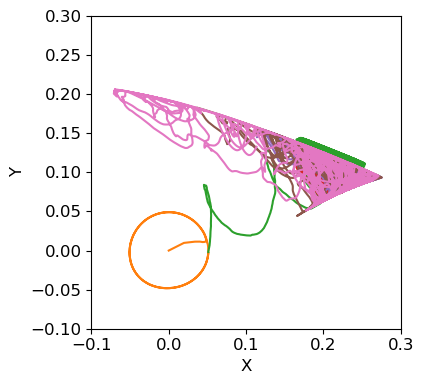

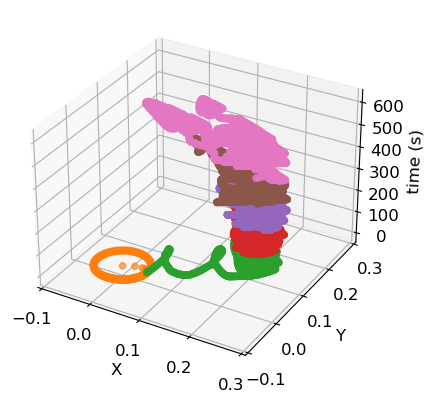

In [16]:
#draw phases
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

colors = [
    "black", #pid init
    "green", #pid movement
    "purple",# open loop
    "orange", #mixed
    "pink",  #closed loop
    "red", #testing
    "black"
]

import matplotlib.pyplot as plt

fig_width = 4.4
fig_height = 4
ncols= 1
nrows = 1
fig, axs = plt.subplots(
            nrows=nrows,
            ncols=1,
            sharey='row', sharex='all',
            figsize=(fig_width,nrows*fig_height),
            squeeze=False)

#X-Y
limX = (-0.1,0.3)
limY = (-0.1,0.3)
for i, phase in enumerate(exp.phases):
    color = colors[i]
    i_start = int(phase["t_start"]/exp.stepSize)
    i_end = int((phase["t_start"]+phase["duration"])/exp.stepSize)
    
    axs[0][0].plot(x[i_start:i_end],y[i_start:i_end])
    
#axs[0][0].set_ylim(0,None)
axs[-1][0].set_xlabel("X")
axs[0][0].set_ylabel("Y")
#axs[0][0].legend()
axs[0][0].set_xlim(limX)
axs[0][0].set_ylim(limY)
#axs[0][0].set_title("Control Inputs")
fig.tight_layout()
    
plt.savefig(exp.workingFolder+"trajectory_X-Y_topdown.svg")
plt.show()


#t-X-Y
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i, phase in enumerate(exp.phases):
    color = colors[i]
    i_start = int(phase["t_start"]/exp.stepSize)
    i_end = int((phase["t_start"]+phase["duration"])/exp.stepSize)
    ax.scatter(x[i_start:i_end],y[i_start:i_end],ts[i_start:i_end])
    ax.set_ylim(limY)
    ax.set_xlim(limX)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("time (s)")

plt.savefig(exp.workingFolder+"trajectory_X-Y-t_3D.svg")
plt.show()



### Popultations

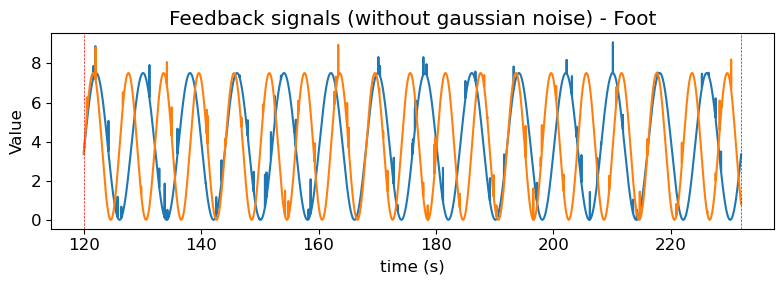

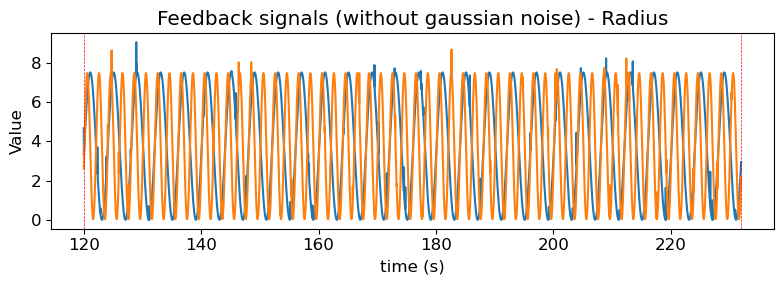

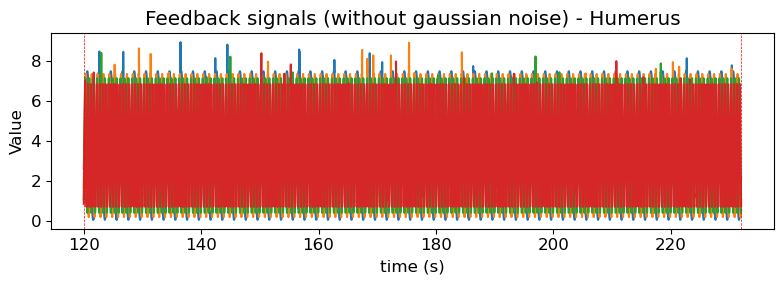

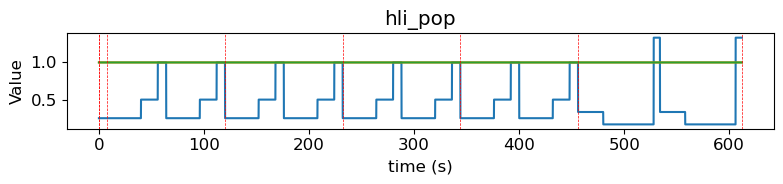

In [17]:
#sensor_pop (feedback)
exp.plotData(
    FORCE_inputs,
    key="sensor_pop",
    title="Feedback signals (without gaussian noise) - Foot",
    selectIndices = [0,1],
    fig_height=3,
    phaseName="FORCE mixed",
    fileName="Feedback_(noGN)_Foot_FORCEmixed.svg",
    legend=False)

#sensor_pop (feedback)
exp.plotData(
    FORCE_inputs,
    key="sensor_pop",
    title="Feedback signals (without gaussian noise) - Radius",
    selectIndices = [2,3],
    fig_height=3,
    phaseName="FORCE mixed",
    fileName="Feedback_(noGN)_Radius_FORCEmixed.svg",
    legend=False)


#sensor_pop (feedback)
exp.plotData(
    FORCE_inputs,
    key="sensor_pop",
    title="Feedback signals (without gaussian noise) - Humerus",
    selectIndices = [4,5,6,7],
    fig_height=3,
    phaseName="FORCE mixed",
    fileName="Feedback_(noGN)_Humerus_FORCEmixed.svg",
    legend=False)

#hli_pop (contol)
exp.plotData(
    FORCE_inputs,
    key="hli_pop",
    #title="Control Inputs (f=blue, X=orange, Y=green)",
    fig_height=2,
    #phaseName="FORCE mixed",
    fileName="Controls.svg",
    legend=False)

### Rate of weight change

In [18]:
new_w_percentChange = []
for i, w in enumerate(SNN_FORCE["new_w"]):
    if w == None or i == 0 or SNN_FORCE["new_w"][i-1] == None:
        new_w_percentChange.append(np.zeros((8,exp.columns)))
    else:
        w_previous = SNN_FORCE["new_w"][i-1]
        
        r = np.array(w)/np.array(w_previous) - 1
        r = r.transpose()
        #print(np.shape(r))
        new_w_percentChange.append(r)
        
new_w_percentChange = np.abs(np.array(new_w_percentChange)*100)

maxima = np.max(new_w_percentChange,axis=2)
#maxima[maxima>1] = 1 #cap at 1
minima = np.min(new_w_percentChange,axis=2)
#minima[minima<-1] = -1 #cap at -1
mean = np.mean(new_w_percentChange,axis=2)
#mean[mean<-1] = -1 #cap at -1
#mean[mean>1] = 1 #cap at 1
median = np.median(new_w_percentChange,axis=2)

#plot overall
ts = SNN_FORCE["time"]

#apply sliding window
from scipy.ndimage import uniform_filter1d

windowSize = 50
x = np.mean(mean, axis=1)
outlierLim = 200
x[x>outlierLim] = outlierLim #remove outlier
y = uniform_filter1d(x, size=windowSize)



#early stopping / plateau detection
# -> if the metric did not imporove within N timepoints, we consider the curve to have plateaued
#N = 1000 #timepoints
#currentMin = float('inf')
#currentMin_i = 0
#n = 0 #distance to last minimum
#ignoreFirst = 500 #ignore first timepoints as the change is rising
#for i,v in enumerate(y[:-ignoreLast]):
#    if v < currentMin or i < ignoreFirst:
#        n = 0
#        currentMin = v
#        currentMin_i = i
#    else:
#        n += 1
#    
#    if(n > N):
#        break      
#print(f"found min={currentMin} at index {currentMin_i} (= {currentMin_i*exp.stepSize} s)")


## *Used in Figure 5.2*

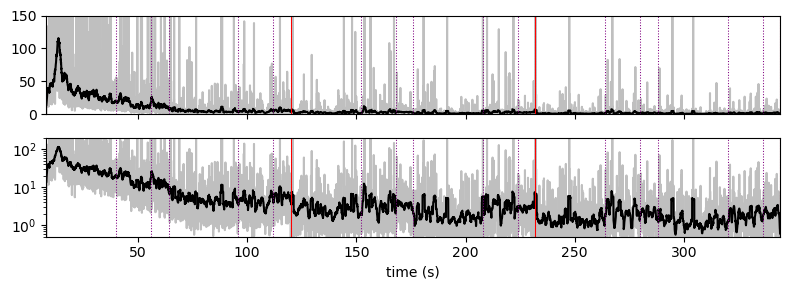

In [19]:
#Weight change
import matplotlib
matplotlib.rcParams.update({'font.size': 10})
self = exp

f,X,Y = np.array(FORCE_inputs["hli_pop"]).transpose()

fig_width = 8
fig_height = 1.5
ncols= 1
nrows = 2
fig, axs = plt.subplots(
            nrows=nrows,
            ncols=1,
            sharey='row', sharex='all',
            figsize=(ncols*fig_width,nrows*fig_height),
            squeeze=False)


axs[0][0].plot(ts,x,alpha=0.25,color="black")
axs[0][0].plot(ts,y,color="black")
axs[1][0].plot(ts,x,alpha=0.25,color="black")
axs[1][0].plot(ts,y,color="black")
#add phases
pColor = ["red", "purple"] #phase, scenario
pStyle = ["-",":"]
pWidth = [0.75, 0.75]
alpha = [1, 1]

#add scenario transitions
for phase in exp.phases:
    axs[0][0].axvline(phase["t_start"], color = pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])
    axs[1][0].axvline(phase["t_start"], color = pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])
    
    if (phase["name"] in ["FORCE open loop","FORCE mixed","FORCE closed loop","FORCE testing"] ):  # -> GT with/without noise
        t_start=phase["t_start"]
        for section in self.subsections:
            duration = phase["periods"]/section["frequency"]
            t_end=t_start+duration
            
            if(phase["t_start"] != t_start):
                axs[0][0].axvline(t_start, color = pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])
                axs[1][0].axvline(t_start, color = pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

            t_start = t_end #update temporal position
        if(phase["t_start"] != t_start):
            axs[0][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])
            axs[1][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

    elif (phase["name"] == "FORCE interpolation"):

        t_start=phase["t_start"]
        for section in self.interpolateSubsections:
            duration = phase["periods"]/section["frequency"]
            t_end=t_start+duration
            if(phase["t_start"] != t_start):
                axs[0][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])
                axs[1][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

            t_start = t_end #update temporal position
        if(phase["t_start"] != t_start):
            axs[0][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])
            axs[1][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

    
axs[0][0].axvline(exp.phases[-1]["t_start"]+exp.phases[-1]["duration"], color =  pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])
axs[1][0].axvline(exp.phases[-1]["t_start"]+exp.phases[-1]["duration"], color =  pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])
    

#axs[0][0].set_ylabel(f'Weight change (%)')
#axs[0][0].legend()
axs[0][0].set_ylim(0.0,150)

#log plot
axs[1][0].set_yscale("log")
axs[1][0].set_xlim((exp.phases[2]["t_start"],exp.phases[5]["t_start"])) #only the three learnign phases
#axs[1][0].title("Overall w change % (mean, filtered, log)")
axs[1][0].set_ylim(5*10**-1,200)
axs[1][0].set_xlabel("time (s)")
#axs[1][0].set_ylabel("Weight change (%)")


fig.tight_layout()
plt.savefig(exp.workingFolder+f"WeightChange.svg")
plt.show()

In [20]:
secs = 10
i_start = int( (exp.phases[5]["t_start"]-secs)/exp.stepSize )
i_end = int( exp.phases[5]["t_start"]/exp.stepSize )

print(f'Mean weight change in the last {secs} seconds = {np.mean(x[i_start:i_end])} %')

Mean weight change in the last 10 seconds = 2.1793427967340513 %


In [21]:
#pop 100
# 0.03 - circel 1
# 0.08 - trans 1

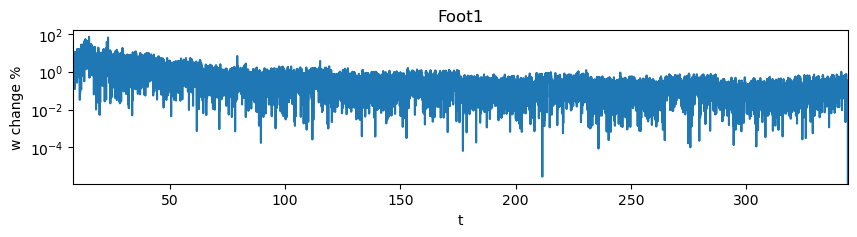

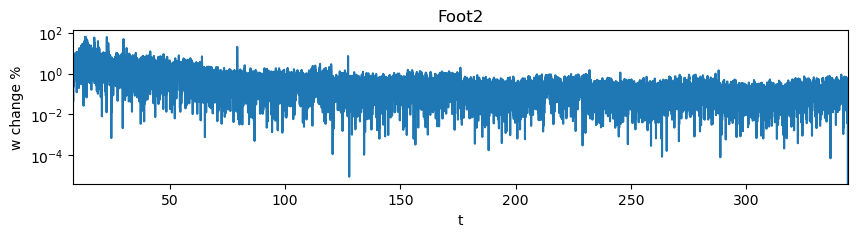

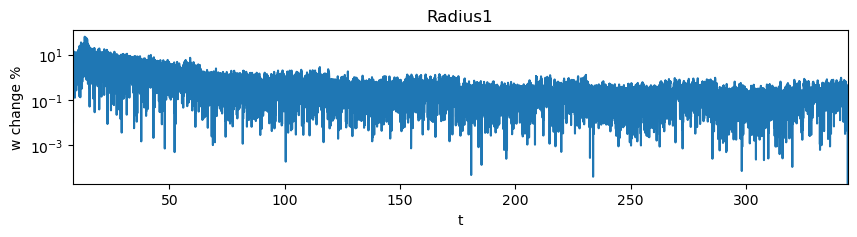

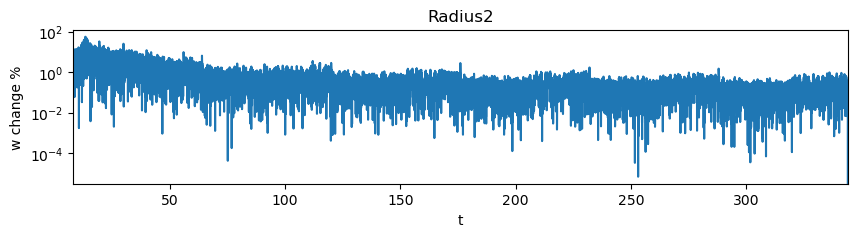

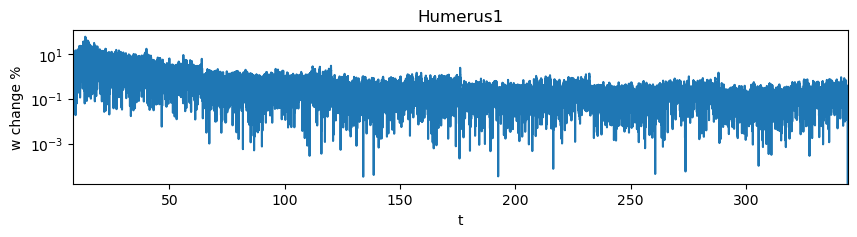

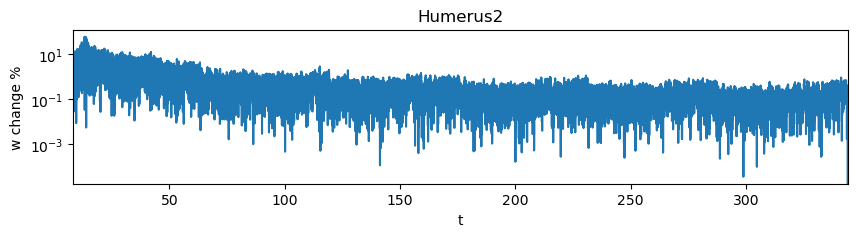

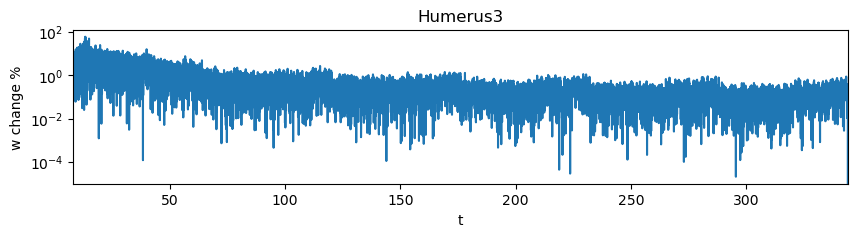

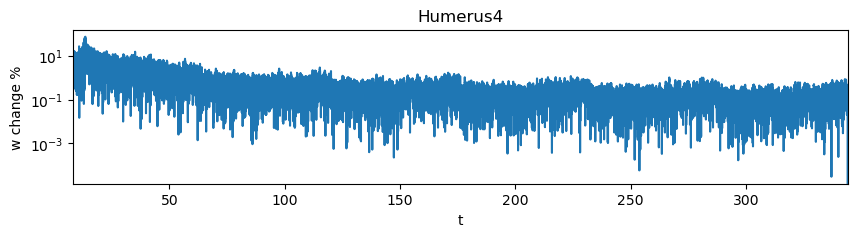

In [22]:
#plot for each muscle
for m, muscleName in enumerate(exp.muscleNames):
    
    plt.figure(figsize=(10, 2))
    #plt.plot(ts,maxima[:,m])
    #plt.plot(ts,mean[:,m])
    plt.plot(ts,median[:,m])
    #plt.plot(ts,minima[:,m])
    #plt.ylim((0,1))
    plt.yscale("log")
    plt.xlim((exp.phases[2]["t_start"],exp.phases[5]["t_start"])) #only the three learnign phases
    plt.title(muscleName)
    plt.ylabel("w change %")
    plt.xlabel("t")
    plt.savefig(exp.workingFolder+f'w_change_{muscleName}.svg')
    plt.show()


### Testing Error

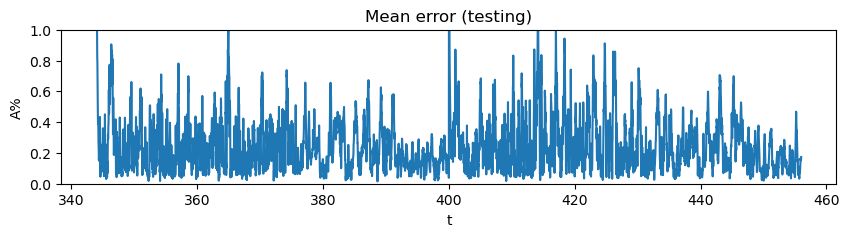

Mean error in testing phase: 0.2427


In [23]:
testingPhase = exp.phases[5]

f = int(testingPhase["t_start"]/exp.stepSize)
t = int((testingPhase["t_start"]+testingPhase["duration"])/exp.stepSize)

ts = SNN_FORCE["time"][f:t]
err = SNN_FORCE["error_abs"][f:t]

plt.figure(figsize=(10, 2))
plt.plot(ts,err)
#plt.yscale("log")
#plt.xlim((exp.phases[2]["t_start"],exp.phases[5]["t_start"])) #only the three learnign phases
plt.title("Mean error (testing)")
plt.ylabel("A%")
plt.xlabel("t")
plt.ylim((0,1))
plt.savefig(exp.workingFolder+f'error_testing_{np.mean(err):.04f}.svg')
plt.show()

print(f"Mean error in testing phase: {np.mean(err):.04f}")


In [24]:
# 60 pop
# 0.1 for f=1

# 100 pop
# 0.119 - c1
# 0.095 - t1
# 0.08 -1 0.01 shot

### Error over time (training)

In [25]:
#TODO: das hier mal besser machen!
thr_mag = 0.17#0.05 #after which w-magnitude vector threshold we assume learning is done

for m, error_abs in enumerate(SNN_FORCE["error_abs"].transpose()):
    
    done_index = None
    magnitudes = SNN_FORCE["new_w_magnitude"].transpose()[m]
    for t, mag in enumerate(magnitudes):
        if mag < thr_mag:
            done_index = t
            break
            
    if(done_index == None):
        raise RuntimeError(f'for muscle {m}, there was no magnitude value smaller than {thr_mag}. (smallest is {np.min(magnitudes)})')
    else:
        print(f'For muscle {m}, first magnitude indicating learning end ({magnitudes[done_index]} < {thr_mag}) at index {done_index} (generel minimum: {np.min(magnitudes)})')
        pass
    mean_err = np.mean(error_abs[done_index:]) #TODO: respect phases
    print(f'Mean error after convergence: {mean_err}')
        
#Tau
# p 240, tau_m 160 -> 0.090
# p 240, tau_m 80 -> 0.13
# p40, tau_m 160 -> 0.17 / 0.166
# p40, tau_m 80 -> 0.21
# -> tau_m = 160 !

# Populations
# 240 -> 0.139
# 500 -> 0.



For muscle 0, first magnitude indicating learning end (0.0 < 0.17) at index 0 (generel minimum: 0.0)
Mean error after convergence: 252.8911283547746


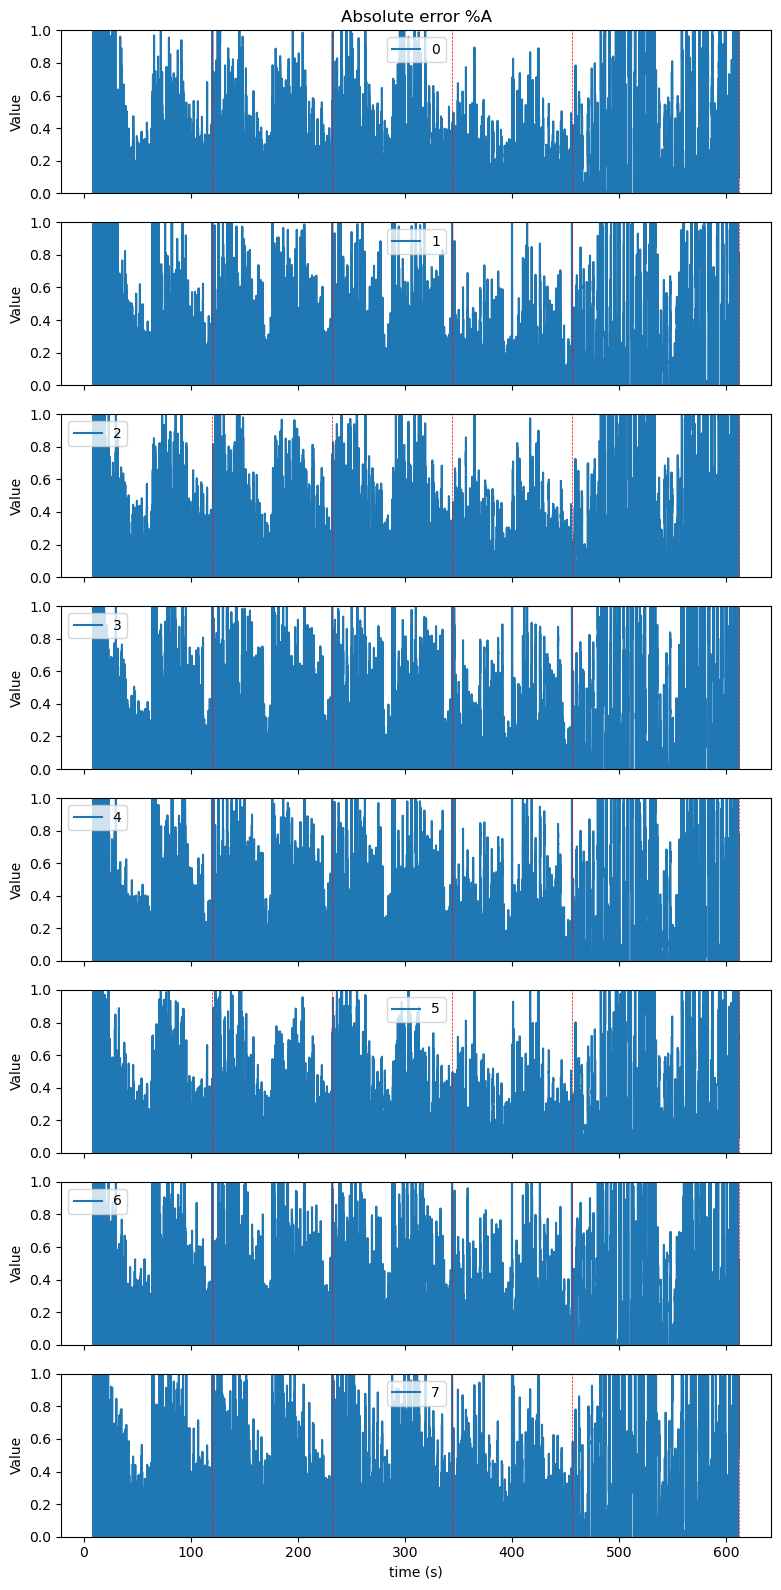

In [26]:
#Error for muscles
#TODO: make plotData accept labels for plots which here should be the mean error after some time
selectIndices = [0,1,2,3,4,5,6,7] #Foot is 0 anyways

exp.plotData(
    SNN_FORCE,
    key="error",
    title="Absolute error %A",
    seperatePlots=True,
    #phaseName="FORCE open loop",
    fig_height = 2,
    selectIndices=selectIndices,
    tlim=(9.2,None),
    ylim=(0,1),
    fileName="error_meanPerMuscle.svg",
    log=False)

stepLim[459, 30600]


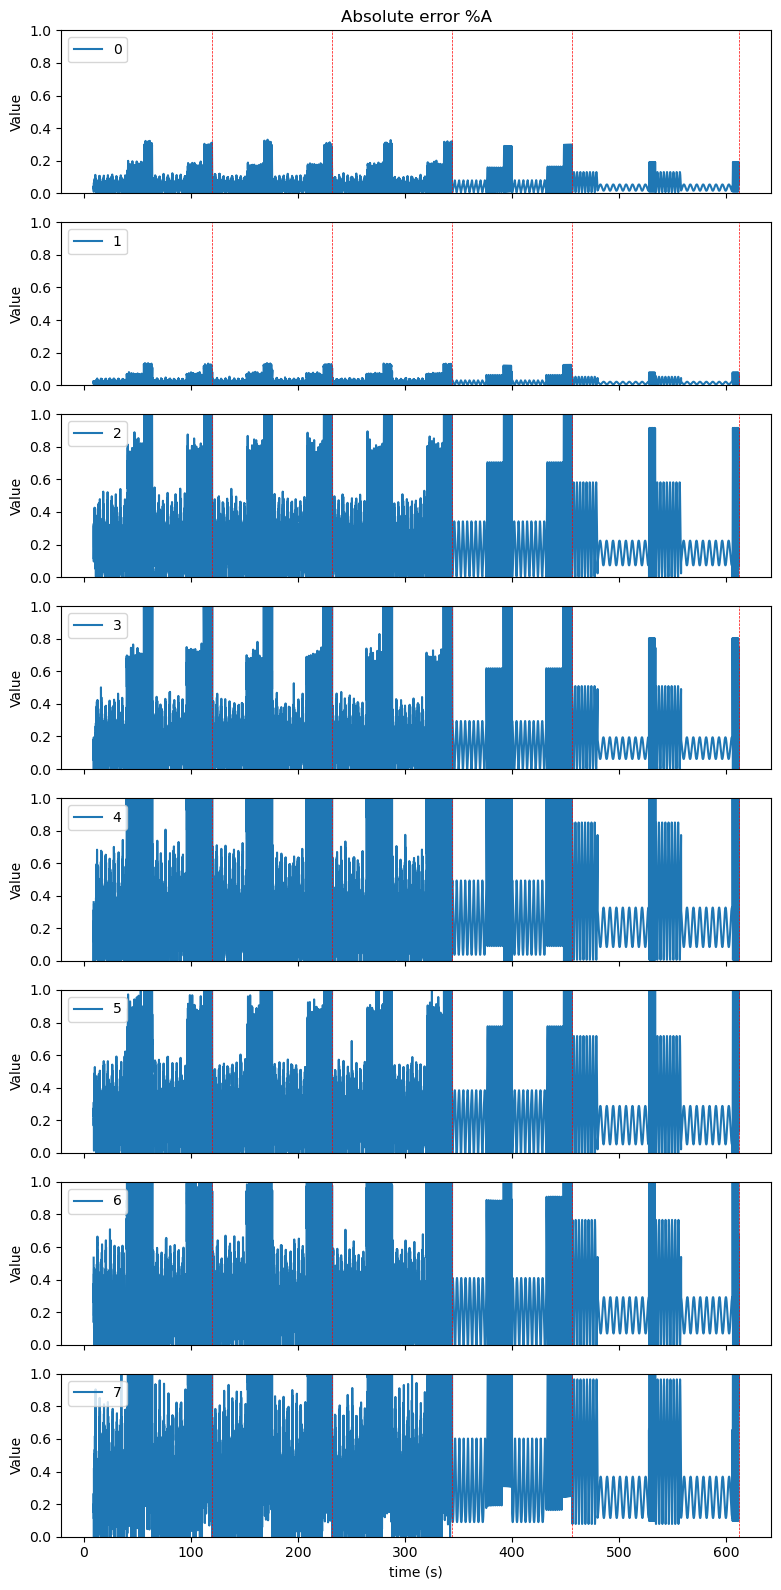

In [27]:
#Values for muscles
#TODO: make plotData accept labels for plots which here should be the mean error after some time
selectIndices = [0,1,2,3,4,5,6,7] #Foot is 0 anyways

exp.plotData(
    exp.MuscleValues_noised,
    title="Absolute error %A",
    seperatePlots=True,
    #phaseName="FORCE open loop",
    fig_height = 2,
    selectIndices=selectIndices,
    tlim=(9.2,None),
    ylim=(0,1),
    fileName="error_meanPerMuscle.svg",
    log=False)

## *Used in Figure 5.5*

FORCE open loop	circle	f=0.25	mean_error=48.32 %
FORCE open loop	circle	f=0.5	mean_error=14.83 %
FORCE open loop	circle	f=1	mean_error=14.88 %
FORCE open loop	circle	f=0.25	mean_error=32.43 %
FORCE open loop	circle	f=0.5	mean_error=19.28 %
FORCE open loop	circle	f=1	mean_error=15.78 %
FORCE mixed	circle	f=0.25	mean_error=32.93 %
FORCE mixed	circle	f=0.5	mean_error=23.22 %
FORCE mixed	circle	f=1	mean_error=15.19 %
FORCE mixed	circle	f=0.25	mean_error=30.53 %
FORCE mixed	circle	f=0.5	mean_error=24.49 %
FORCE mixed	circle	f=1	mean_error=15.33 %
FORCE closed lo	circle	f=0.25	mean_error=31.87 %
FORCE closed lo	circle	f=0.5	mean_error=25.58 %
FORCE closed lo	circle	f=1	mean_error=14.50 %
FORCE closed lo	circle	f=0.25	mean_error=29.73 %
FORCE closed lo	circle	f=0.5	mean_error=25.66 %
FORCE closed lo	circle	f=1	mean_error=17.44 %
FORCE testing	circle	f=0.25	mean_error=25.07 %
FORCE testing	circle	f=0.5	mean_error=24.12 %
FORCE testing	circle	f=1	mean_error=14.98 %
FORCE testing	circle	f=0.25	m

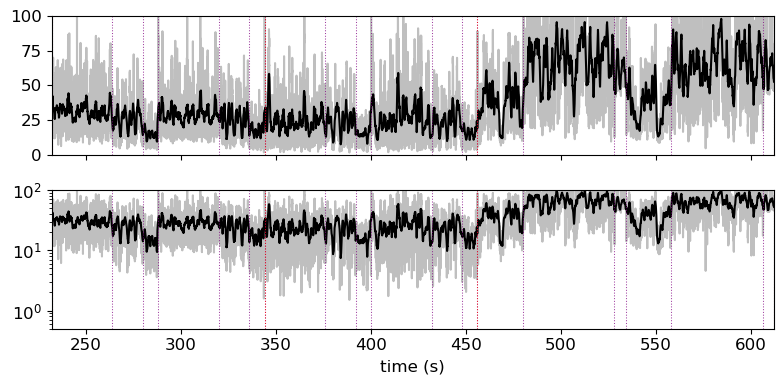

In [28]:
#Error over time

#Data preperation
#from_phase = 1
#to_phase = 2
from_phase = 4
to_phase = 6

from scipy.ndimage import uniform_filter1d

f = int(exp.phases[from_phase]["t_start"]/exp.stepSize)
t = int((exp.phases[to_phase]["t_start"]+exp.phases[to_phase]["duration"])/exp.stepSize)-1 

x = SNN_FORCE["error_abs"].flatten()*100
outlierLim = 100
x[x>outlierLim] = outlierLim #remove outlier
windowSize=50
y = uniform_filter1d(x, size=windowSize)

#Drawing
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
self = exp

fig_width = 8
fig_height = 2
ncols= 1
nrows = 2
fig, axs = plt.subplots(
            nrows=nrows,
            ncols=1,
            sharey='row', sharex='all',
            figsize=(ncols*fig_width,nrows*fig_height),
            squeeze=False)

ts = SNN_FORCE["time"]
axs[0][0].plot(ts,x,alpha=0.25,color="black")
axs[0][0].plot(ts,y,color="black")
axs[1][0].plot(ts,x,alpha=0.25,color="black")
axs[1][0].plot(ts,y,color="black")

#add phases
pColor = ["red", "purple"] #phase, scenario
pStyle = [":",":"]
pWidth = [0.75, 0.75]
alpha = [0.75, 0.75]

for row in range(nrows):
    for phase in exp.phases:
        axs[row][0].axvline(phase["t_start"], color = pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])

        if (phase["name"] in ["FORCE open loop","FORCE mixed","FORCE closed loop","FORCE testing"] ):  # -> GT with/without noise
            t_start=phase["t_start"]
            for section in self.subsections:
                duration = phase["periods"]/section["frequency"]
                t_end=t_start+duration
                
                if(row == 0):
                    i1 = int(t_start/exp.stepSize)
                    i2 = int(t_end/exp.stepSize)
                    m = np.mean(x[i1:i2])
                    print(f'{phase["name"][:15]}\t{section["scenario"]}\tf={section["frequency"]}\tmean_error={m:.02f} %')
                    
                if(phase["t_start"] != t_start):
                    axs[row][0].axvline(t_start, color = pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

                t_start = t_end #update temporal position
            if(phase["t_start"] != t_start):
                axs[row][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

        elif (phase["name"] == "FORCE interpolation"):

            t_start=phase["t_start"]
            for section in self.interpolateSubsections:
                duration = phase["periods"]/section["frequency"]
                t_end=t_start+duration
                
                if(row == 0):
                    i1 = int(t_start/exp.stepSize)
                    i2 = int(t_end/exp.stepSize)
                    m = np.mean(x[i1:i2])
                    print(f'{phase["name"][:15]}\t{section["scenario"]}\tf={section["frequency"]}\tmean_error={m:.02f} %')

                if(phase["t_start"] != t_start):
                    axs[row][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

                t_start = t_end #update temporal position
            if(phase["t_start"] != t_start):
                axs[row][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

    axs[row][0].axvline(exp.phases[-1]["t_start"]+exp.phases[-1]["duration"], color =  pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])
    

#axs[0][0].set_ylabel(f'Weight change (%)')
#axs[0][0].legend()
axs[0][0].set_ylim(0.0,100)

#log plot
axs[1][0].set_yscale("log")
axs[1][0].set_xlim((exp.phases[from_phase]["t_start"],exp.phases[to_phase]["t_start"]+exp.phases[to_phase]["duration"])) #only the three learnign phases
#axs[1][0].title("Overall w change % (mean, filtered, log)")
axs[1][0].set_ylim(0.5*10**0,100)
axs[1][0].set_xlabel("time (s)")
#axs[1][0].set_ylabel("Weight change (%)")
plt.tight_layout()
plt.savefig(exp.workingFolder+f'error_p{from_phase}_p{to_phase}.svg')
plt.show()


## *Used in Figure 5.5*

FORCE open loop	circle	f=0.25	mean_error=0.2667
FORCE open loop	circle	f=0.5	mean_error=0.0821
FORCE open loop	circle	f=1	mean_error=0.1907
FORCE open loop	circle	f=0.25	mean_error=0.0919
FORCE open loop	circle	f=0.5	mean_error=0.1192
FORCE open loop	circle	f=1	mean_error=0.2060
FORCE mixed	circle	f=0.25	mean_error=0.0925
FORCE mixed	circle	f=0.5	mean_error=0.1473
FORCE mixed	circle	f=1	mean_error=0.1993
FORCE mixed	circle	f=0.25	mean_error=0.0847
FORCE mixed	circle	f=0.5	mean_error=0.1555
FORCE mixed	circle	f=1	mean_error=0.2122
FORCE closed lo	circle	f=0.25	mean_error=0.0911
FORCE closed lo	circle	f=0.5	mean_error=0.1641
FORCE closed lo	circle	f=1	mean_error=0.1980
FORCE closed lo	circle	f=0.25	mean_error=0.0808
FORCE closed lo	circle	f=0.5	mean_error=0.1655
FORCE closed lo	circle	f=1	mean_error=0.2349
FORCE testing	circle	f=0.25	mean_error=0.0844
FORCE testing	circle	f=0.5	mean_error=0.1631
FORCE testing	circle	f=1	mean_error=0.2023
FORCE testing	circle	f=0.25	mean_error=0.0928
FORC

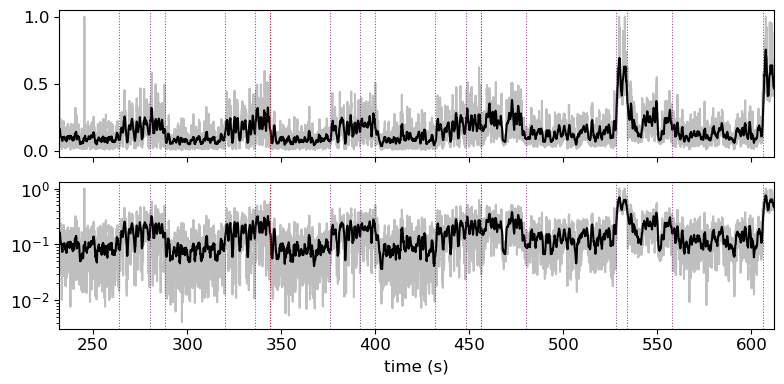

In [29]:
#Error over time (ABSOLUTE)

#Data preperation
#from_phase = 1
#to_phase = 2
from_phase = 4
to_phase = 6

from scipy.ndimage import uniform_filter1d

f = int(exp.phases[from_phase]["t_start"]/exp.stepSize)
t = int((exp.phases[to_phase]["t_start"]+exp.phases[to_phase]["duration"])/exp.stepSize)-1 

v = np.array(SNN_FORCE["readout"])
gt = np.array(exp.MuscleValues)
err = np.abs(v-gt)
mean_err = np.mean(err,axis=1)

x = mean_err
outlierLim = 1
x[x>outlierLim] = outlierLim #remove outlier
windowSize=50
y = uniform_filter1d(x, size=windowSize)

#Drawing
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
self = exp

fig_width = 8
fig_height = 2
ncols= 1
nrows = 2
fig, axs = plt.subplots(
            nrows=nrows,
            ncols=1,
            sharey='row', sharex='all',
            figsize=(ncols*fig_width,nrows*fig_height),
            squeeze=False)

ts = SNN_FORCE["time"]
axs[0][0].plot(ts,x,alpha=0.25,color="black")
axs[0][0].plot(ts,y,color="black")
axs[1][0].plot(ts,x,alpha=0.25,color="black")
axs[1][0].plot(ts,y,color="black")

#add phases
pColor = ["red", "purple"] #phase, scenario
pStyle = [":",":"]
pWidth = [0.75, 0.75]
alpha = [0.75, 0.75]

for row in range(nrows):
    for phase in exp.phases:
        axs[row][0].axvline(phase["t_start"], color = pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])

        if (phase["name"] in ["FORCE open loop","FORCE mixed","FORCE closed loop","FORCE testing"] ):  # -> GT with/without noise
            t_start=phase["t_start"]
            for section in self.subsections:
                duration = phase["periods"]/section["frequency"]
                t_end=t_start+duration
                
                if(row == 0):
                    i1 = int(t_start/exp.stepSize)
                    i2 = int(t_end/exp.stepSize)
                    m = np.mean(x[i1:i2])
                    print(f'{phase["name"][:15]}\t{section["scenario"]}\tf={section["frequency"]}\tmean_error={m:.04f}')
                    
                if(phase["t_start"] != t_start):
                    axs[row][0].axvline(t_start, color = pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

                t_start = t_end #update temporal position
            if(phase["t_start"] != t_start):
                axs[row][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

        elif (phase["name"] == "FORCE interpolation"):

            t_start=phase["t_start"]
            for section in self.interpolateSubsections:
                duration = phase["periods"]/section["frequency"]
                t_end=t_start+duration
                
                if(row == 0):
                    i1 = int(t_start/exp.stepSize)
                    i2 = int(t_end/exp.stepSize)
                    m = np.mean(x[i1:i2])
                    print(f'{phase["name"][:15]}\t{section["scenario"]}\tf={section["frequency"]}\tmean_error={m:.04f}')

                if(phase["t_start"] != t_start):
                    axs[row][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

                t_start = t_end #update temporal position
            if(phase["t_start"] != t_start):
                axs[row][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

    axs[row][0].axvline(exp.phases[-1]["t_start"]+exp.phases[-1]["duration"], color =  pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])
    

#axs[0][0].set_ylabel(f'Weight change (%)')
#axs[0][0].legend()
#axs[0][0].set_ylim(0.0,100)

#log plot
axs[1][0].set_yscale("log")
axs[1][0].set_xlim((exp.phases[from_phase]["t_start"],exp.phases[to_phase]["t_start"]+exp.phases[to_phase]["duration"])) #only the three learnign phases
#axs[1][0].title("Overall w change % (mean, filtered, log)")
#axs[1][0].set_ylim(0.5*10**0,100)
axs[1][0].set_xlabel("time (s)")
#axs[1][0].set_ylabel("Weight change (%)")
plt.tight_layout()
plt.savefig(exp.workingFolder+f'error_abs_p{from_phase}_p{to_phase}.svg')
plt.show()


In [30]:
#pop 60
# f=1
# 0.063
# 0.12 mit tau 320
# f=0.25
# 0.09
# 0.06 mit tau 360

#pop 100
# 0.0787 - c1
# 0.06 -t1



#pop 260
# 0.10

### Signal GT vs Produced

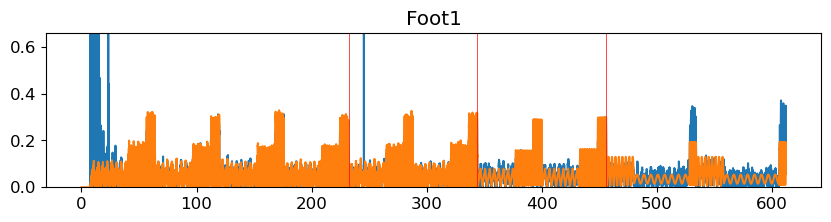

Mean absolute error for above muscle: 3.6339
Max absolute error for above muscle: 3285.0613


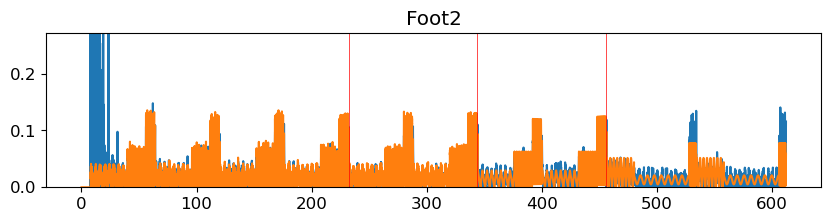

Mean absolute error for above muscle: 9.1699
Max absolute error for above muscle: 6593.1050


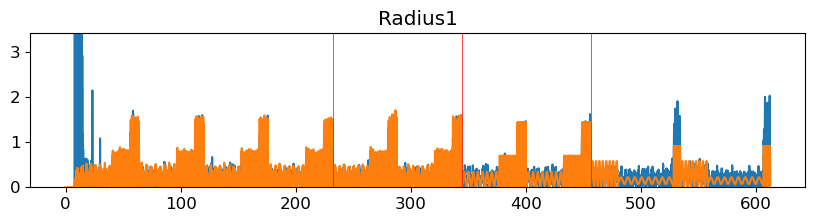

Mean absolute error for above muscle: 1.0487
Max absolute error for above muscle: 640.3154


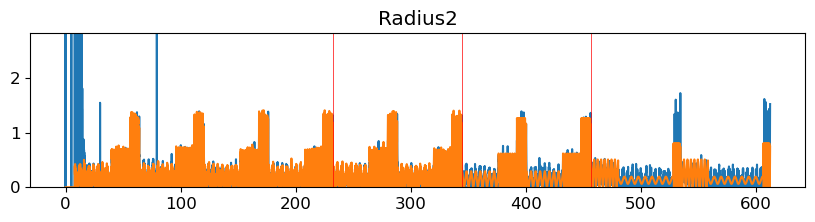

Mean absolute error for above muscle: 1.2047
Max absolute error for above muscle: 632.5150


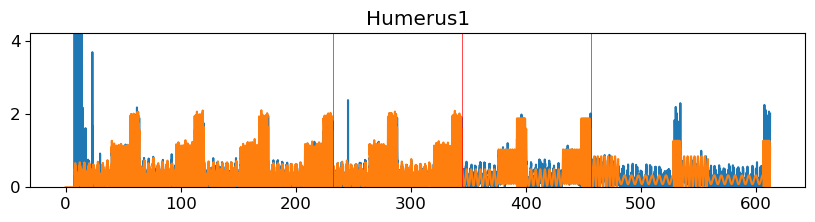

Mean absolute error for above muscle: 0.8868
Max absolute error for above muscle: 450.6298


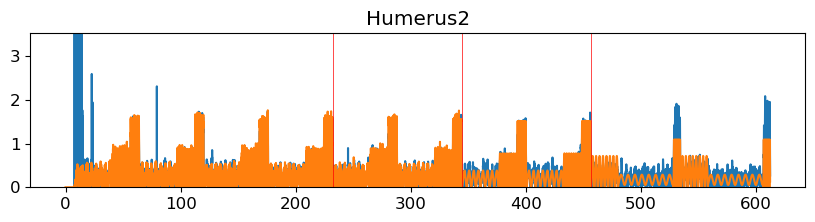

Mean absolute error for above muscle: 0.8838
Max absolute error for above muscle: 598.0447


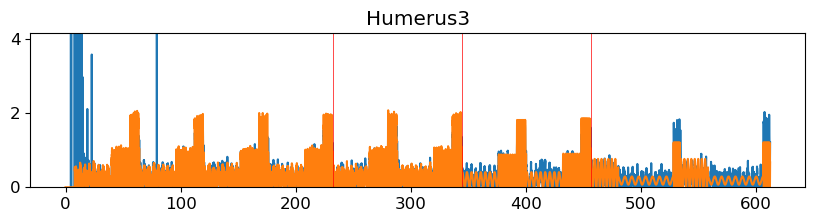

Mean absolute error for above muscle: 0.8985
Max absolute error for above muscle: 425.8271


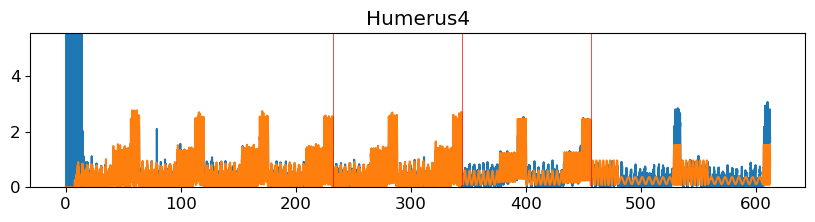

Mean absolute error for above muscle: 0.8143
Max absolute error for above muscle: 428.1158


In [31]:

#Overlay plot
showNoised = True

#selectIndices = [7]#[2,3,4,5,6,7] #Foot is 0 anyways
selectIndices = [0,1,2,3,4,5,6,7] #Foot is 0 anyways
M = len(SNN_FORCE["readout"][0]) # M=amount muscles
ts = SNN_FORCE["time"]
signals = np.array(SNN_FORCE["readout"]).transpose() #should have shape (M, T) where T=timestamps

error = np.abs(np.array(SNN_FORCE["error"]))
for m in range(M):
    if(not m in selectIndices):
        continue

    if(showNoised):
        GT = np.array(exp.MuscleValues_noised).transpose()[m]
    else:
        GT = np.array(exp.MuscleValues).transpose()[m]
    signal = signals[m]#SNN_FORCE["readout"]

    plt.figure(figsize=(10, 2))
    plt.plot(ts,signal,label="signal")
    plt.plot(ts,GT[:len(ts)],label="GT")
    plt.title(exp.muscleNames[m])
    plt.ylim(0,max(GT)*2)
    for phase in exp.phases[from_phase:to_phase+1]:
        plt.vlines(x=phase["t_start"],ymin=min(signal),ymax=max(signal),color = "red", lw=0.5)
        
    plt.savefig(exp.workingFolder+f'signalVSgt_{exp.muscleNames[m]}.svg')
    plt.show()
    
    print(f'Mean absolute error for above muscle: {np.mean(error[:,m][done_index+500:]):.04f}')
    print(f'Max absolute error for above muscle: {np.max(error[:,m][done_index+500:]):.04f}')
    

## *Used in Figure 5.4*

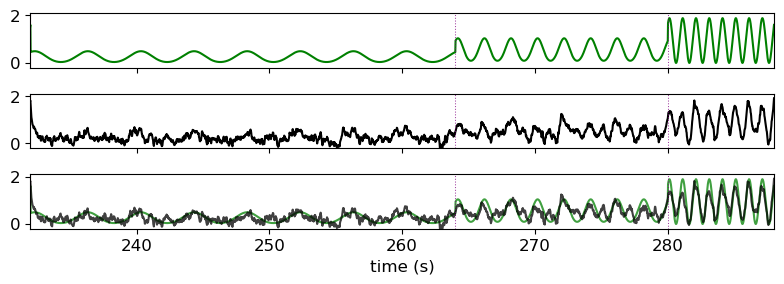

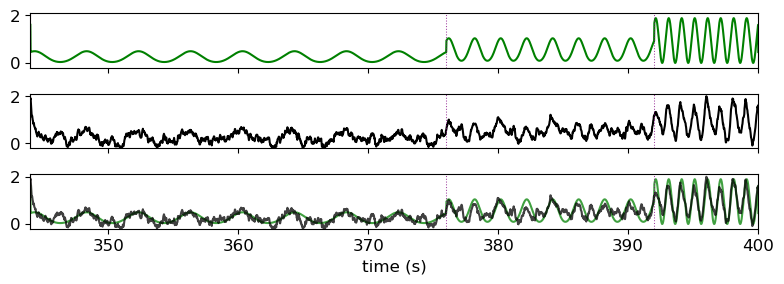

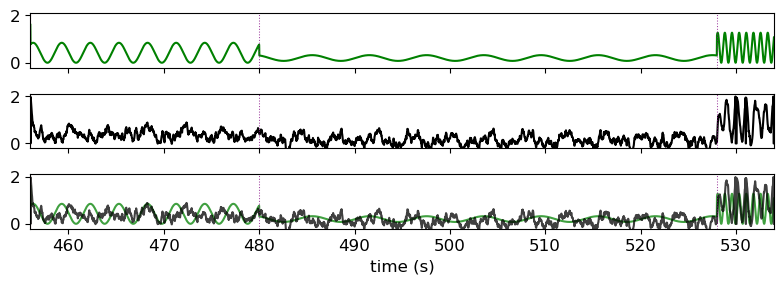

In [32]:
#Example muscle values

m_i = 4 #humerus1

from scipy.ndimage import uniform_filter1d

#Data preperation
for phase_i in [4,5,6]:
    #phase_i = 4 #train
    #phase_i = 5 #testing
    #phase_i = 6 #interp

    f = int(exp.phases[phase_i]["t_start"]/exp.stepSize)
    t = int((exp.phases[phase_i]["t_start"]+exp.phases[phase_i]["duration"])/exp.stepSize)-1 

    x = np.array(SNN_FORCE["readout"])[:,m_i]
    x[x>2]=0
    x[x<-1]=0
    gt = np.array(exp.MuscleValues)[:,m_i]
    
    #smooth gt
    windowSize=50
    gt_smooth = uniform_filter1d(gt, size=windowSize)
    #x_smooth = uniform_filter1d(x, size=10)

    #Drawing
    import matplotlib
    matplotlib.rcParams.update({'font.size': 12})
    self = exp

    fig_width = 8
    fig_height = 1
    ncols= 1
    nrows = 3
    fig, axs = plt.subplots(
                nrows=nrows,
                ncols=1,
                sharey='row', sharex='all',
                figsize=(ncols*fig_width,nrows*fig_height),
                squeeze=False)

    ts = SNN_FORCE["time"]
    #gt only
    axs[0][0].plot(ts,gt,alpha=1,color="green")
    #readout only
    axs[1][0].plot(ts,x,alpha=1,color="black")
    #axs[1][0].plot(ts,x_smooth,alpha=1,color="black")
    #overly
    axs[2][0].plot(ts,gt,alpha=0.75,color="green")
    axs[2][0].plot(ts,x,alpha=0.75,color="black")
    #axs[2][0].plot(ts,x_smooth,alpha=1,color="black")
    #axs[2][0].plot(ts,err,alpha=0.75,color="red")

    #add phases
    pColor = ["red", "purple"] #phase, scenario
    pStyle = ["-",":"]
    pWidth = [0.75, 0.75]
    alpha = [0.75, 0.75]

    for row in range(nrows):
        for phase in exp.phases:
            axs[row][0].axvline(phase["t_start"], color = pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])

            if (phase["name"] in ["FORCE open loop","FORCE mixed","FORCE closed loop","FORCE testing"] ):  # -> GT with/without noise
                t_start=phase["t_start"]
                for section in self.subsections:
                    duration = phase["periods"]/section["frequency"]
                    t_end=t_start+duration

                    if(phase["t_start"] != t_start):
                        axs[row][0].axvline(t_start, color = pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

                    t_start = t_end #update temporal position
                if(phase["t_start"] != t_start):
                    axs[row][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

            elif (phase["name"] == "FORCE interpolation"):

                t_start=phase["t_start"]
                for section in self.interpolateSubsections:
                    duration = phase["periods"]/section["frequency"]
                    t_end=t_start+duration

                    if(phase["t_start"] != t_start):
                        axs[row][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

                    t_start = t_end #update temporal position
                if(phase["t_start"] != t_start):
                    axs[row][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

        axs[row][0].axvline(exp.phases[-1]["t_start"]+exp.phases[-1]["duration"], color =  pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])

    #log plot
    #axs[1][0].set_yscale("log")
    axs[0][0].set_xlim((exp.phases[phase_i]["t_start"],exp.phases[phase_i]["t_start"]+exp.phases[phase_i]["duration"]/2)) #only the three learnign phases
    axs[0][0].set_ylim(np.min(gt)-0.2,np.max(gt)+0.2)
    axs[1][0].set_ylim(np.min(gt)-0.2,np.max(gt)+0.2)
    axs[2][0].set_ylim(np.min(gt)-0.2,np.max(gt)+0.2)

    #axs[1][0].title("Overall w change % (mean, filtered, log)")

    axs[2][0].set_xlabel("time (s)")
    #axs[1][0].set_ylabel("Weight change (%)")
    plt.tight_layout()
    plt.savefig(exp.workingFolder+f'examples_m={m_i}_p={phase_i}.svg')
    plt.show()



## Transition Smoothing

In [33]:
#TODO: implement an filter you think is euql to the SNN smoothing. An overly plot woul dbe nice
def filter1(x,p=0.8):
    curr = 0
    
    y = []
    for v in x:
        y.append(v)
    
    return y
    
    

## *Used in Figure 5.7*

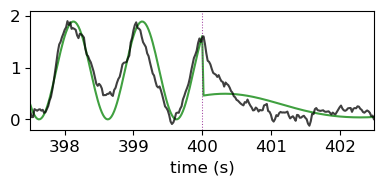

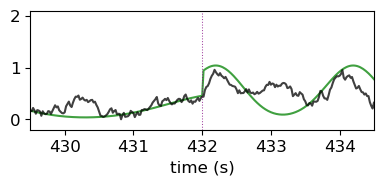

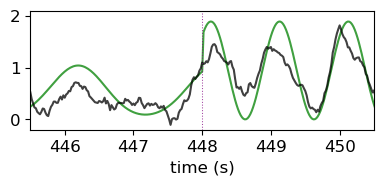

In [34]:
#Example muscle values
from scipy.signal import savgol_filter

m_i = 4 #humerus1

from scipy.ndimage import uniform_filter1d

#Data preperation
if len(exp.frequencies) > 1: #speed experiment
    positions = {
        exp.phases[5]["t_start"]+exp.phases[5]["duration"]/2,
        exp.phases[5]["t_start"]+exp.phases[5]["duration"]/2+(1/exp.frequencies[0])*testP,
        exp.phases[5]["t_start"]+exp.phases[5]["duration"]/2+(1/exp.frequencies[0])*testP+(1/exp.frequencies[1])*testP
    }
else: #pattern experiment
    positions = {
        exp.phases[5]["t_start"]+exp.phases[5]["duration"]/2,
        exp.phases[5]["t_start"]+exp.phases[5]["duration"]/2+(1/exp.frequencies[0])*testP
        #exp.phases[5]["t_start"]+exp.phases[5]["duration"]/2+(1/exp.frequencies[0])*testP
    }

context = 2.5 #seconds

for time_point in positions:
    #phase_i = 4 #train
    #phase_i = 5 #testing
    #phase_i = 6 #interp

    f = int(exp.phases[phase_i]["t_start"]/exp.stepSize)
    t = int((exp.phases[phase_i]["t_start"]+exp.phases[phase_i]["duration"])/exp.stepSize)-1 

    x = np.array(SNN_FORCE["readout"])[:,m_i]
    x[x>2]=0
    x[x<-1]=0
    gt = np.array(exp.MuscleValues)[:,m_i]
    
    #smooth gt
    windowSize=50
    gt_slidingWindow = uniform_filter1d(gt, size=30)
    gt_savgol_filter = savgol_filter(gt,window_length=40, polyorder=5)
    gt_filter1 = filter1(gt)
    #x_smooth = uniform_filter1d(x, size=10)

    #Drawing
    import matplotlib
    matplotlib.rcParams.update({'font.size': 12})
    self = exp

    fig_width = 4
    fig_height = 2
    ncols= 1
    nrows = 1
    fig, axs = plt.subplots(
                nrows=nrows,
                ncols=1,
                sharey='row', sharex='all',
                figsize=(ncols*fig_width,nrows*fig_height),
                squeeze=False)

    ts = SNN_FORCE["time"]
    #gt only
    #axs[0][0].plot(ts,gt,alpha=1,color="green")
    #readout only
    #axs[1][0].plot(ts,x,alpha=1,color="black")
    #axs[1][0].plot(ts,x_smooth,alpha=1,color="black")
    #overly
    axs[0][0].plot(ts,gt,alpha=0.75,color="green")
    axs[0][0].plot(ts,x,alpha=0.75,color="black")
    #axs[0][0].plot(ts,gt_slidingWindow,alpha=0.75,color="red")
    #axs[0][0].plot(ts,gt_savgol_filter,alpha=0.75,color="blue")
    #axs[0][0].plot(ts,gt_filter1,alpha=0.75,color="red")
    
    
    #axs[2][0].plot(ts,x_smooth,alpha=1,color="black")
    #axs[2][0].plot(ts,err,alpha=0.75,color="red")

    #add phases
    pColor = ["red", "purple"] #phase, scenario
    pStyle = ["-",":"]
    pWidth = [0.75, 0.75]
    alpha = [0.75, 0.75]

    for row in range(nrows):
        for phase in exp.phases:
            axs[row][0].axvline(phase["t_start"], color = pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])

            if (phase["name"] in ["FORCE open loop","FORCE mixed","FORCE closed loop","FORCE testing"] ):  # -> GT with/without noise
                t_start=phase["t_start"]
                for section in self.subsections:
                    duration = phase["periods"]/section["frequency"]
                    t_end=t_start+duration

                    if(phase["t_start"] != t_start):
                        axs[row][0].axvline(t_start, color = pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

                    t_start = t_end #update temporal position
                if(phase["t_start"] != t_start):
                    axs[row][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

            elif (phase["name"] == "FORCE interpolation"):

                t_start=phase["t_start"]
                for section in self.interpolateSubsections:
                    duration = phase["periods"]/section["frequency"]
                    t_end=t_start+duration

                    if(phase["t_start"] != t_start):
                        axs[row][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

                    t_start = t_end #update temporal position
                if(phase["t_start"] != t_start):
                    axs[row][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

        axs[row][0].axvline(exp.phases[-1]["t_start"]+exp.phases[-1]["duration"], color =  pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])

    #log plot
    #axs[1][0].set_yscale("log")
    axs[0][0].set_xlim((time_point-context,time_point+context)) #only the three learnign phases
    axs[0][0].set_ylim(np.min(gt)-0.2,np.max(gt)+0.2)
    #axs[1][0].set_ylim(np.min(gt)-0.2,np.max(gt)+0.2)
    #axs[2][0].set_ylim(np.min(gt)-0.2,np.max(gt)+0.2)

    #axs[1][0].title("Overall w change % (mean, filtered, log)")

    axs[-1][0].set_xlabel("time (s)")
    #axs[1][0].set_ylabel("Weight change (%)")
    plt.tight_layout()
    plt.savefig(exp.workingFolder+f'transition_m={m_i}_p={phase_i}_t={time_point}_+-{context}.svg')
    plt.show()

### Magnitude of new weights

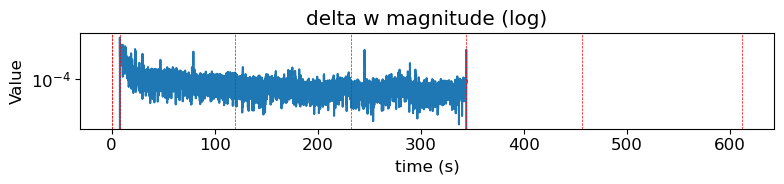

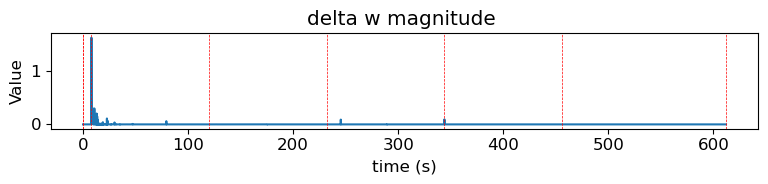

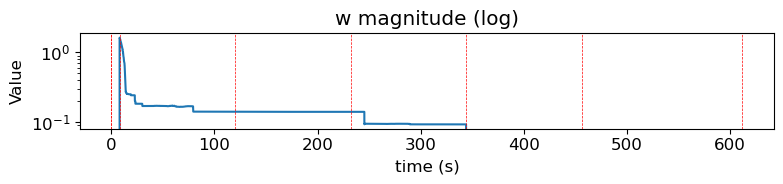

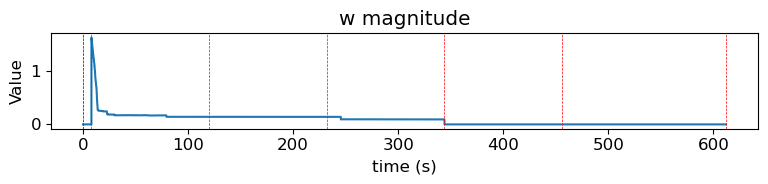

In [35]:
#TODO: fix wenn diff 0 ist das da auch noch werte sind

selectIndices=[7]

#plotData(SNN_FORCE, key="new_w_diff", legend=False)
exp.plotData(SNN_FORCE, key="new_w_diff_magnitude", title="delta w magnitude (log)", legend=False, log=True
         #,phaseName = "FORCE open loop"
             ,selectIndices=selectIndices
             ,fig_height=2
            ,fileName="w_diff_magnitude_log.svg"
        )
exp.plotData(SNN_FORCE, key="new_w_diff_magnitude", title="delta w magnitude ", legend=False, log=False
             #,tlim=(8,None),
             #,phaseName = "FORCE open loop"
             ,selectIndices=selectIndices
             ,fig_height=2
            ,fileName="w_diff_magnitude.svg"
        )
exp.plotData(SNN_FORCE, key="new_w_magnitude", title="w magnitude (log)", legend=False, log=True
             #,phaseName = "FORCE open loop"
             ,selectIndices=selectIndices
             ,fig_height=2
            ,fileName="w_magnitude_log.svg"
        )
exp.plotData(SNN_FORCE, key="new_w_magnitude", title="w magnitude", legend=False
             #,tlim=(8,None)
             #,phaseName = "FORCE open loop"
             ,selectIndices=selectIndices
             ,fig_height=2
             
            ,fileName="w_magnitude_log.svg"
        )


### Monitor neurons

In [36]:


frequency_control = []
X_control = []
Y_control = []

for section in exp.interpolateSubsections:
    #controls
    f = section["frequency"]
    X = section["x_A"]/section["A_max"]
    Y = section["y_A"]/section["A_max"]
    print(section["A_max"])
    #duration
    duration = phase["periods"]/f
    steps_section = int(duration/exp.stepSize)  # steps in this phase
    frequency_control.extend( [f]*steps_section )
    X_control.extend( [X]*steps_section )
    Y_control.extend( [Y]*steps_section )


0.05
0.05
0.05
0.05
0.05
0.05


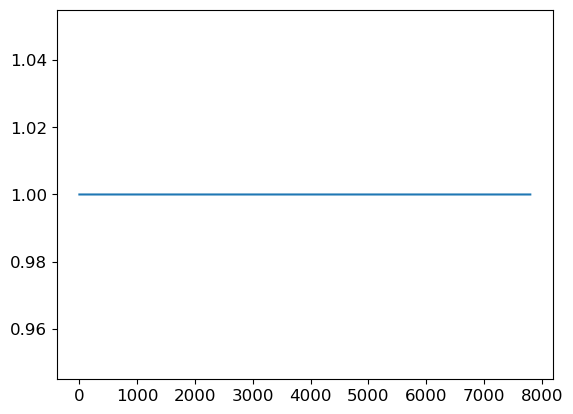

In [37]:
plt.figure()
#plt.plot(exp.controlValues["X"])
plt.plot(X_control)
plt.show()

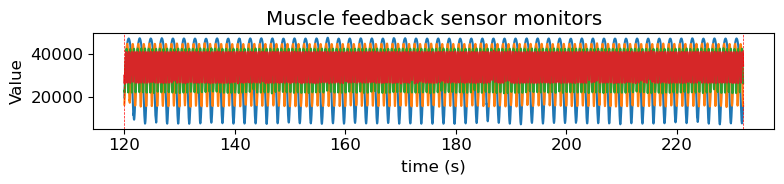

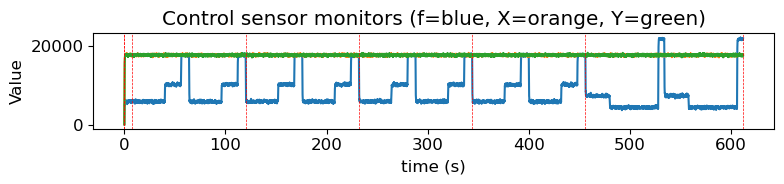

In [38]:
# Monitors on Sensor values (inputs)

exp.plotData(SNN_FORCE,
         key="sensor_monitor_1",
         title="Muscle feedback sensor monitors",
         phaseName="FORCE mixed",
         selectIndices=[4,5,6,7],
         seperatePlots = False,
         fig_height=2,
         tlim=(None,None),
         fileName="feedback_signals_FORCEmixed.svg",
         legend=False) #for muscle feedback

exp.plotData(SNN_FORCE,
         key="sensor_monitor_2",
         title="Control sensor monitors (f=blue, X=orange, Y=green)",
         #phaseName="FORCE mixed",
         #seperatePlots = True,
         fig_height=2,
         tlim=(None,None),
         fileName="control_signals_FORCEmixed.svg",
         legend=False) #for control values#reservoir monitors


## *Used in Figure 4.7*

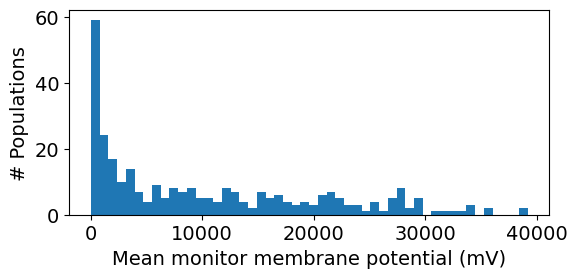

Offline <100: 29/300 (9.666666666666666%)
Offline <1000: 70/300 (23.333333333333332%)


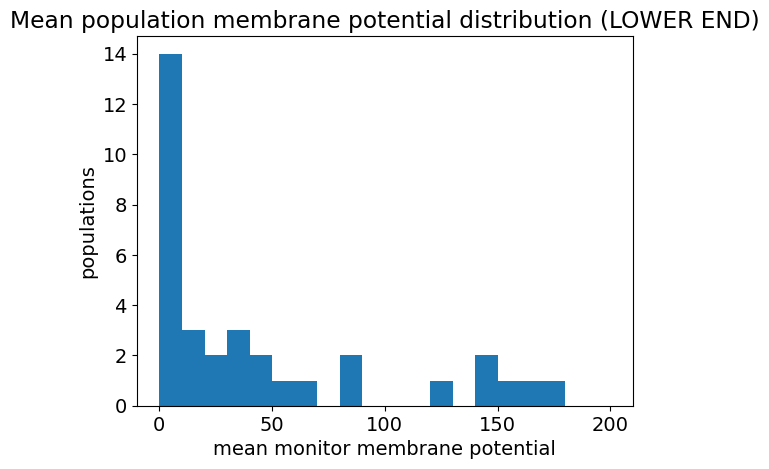

In [39]:
#Distribution of mean population membrane potential
matplotlib.rcParams.update({'font.size': 14})

fig_width = 6
fig_height = 3
nrows = 1
fig, axs = plt.subplots(
            nrows=nrows,
            ncols=1,
            sharey='row', sharex='all',
            figsize=(fig_width,nrows*fig_height),
            squeeze=False)

means = np.mean(np.array(SNN_FORCE["reservoir_state"]).transpose(),axis=1)
#plt.scatter(np.arange(len(means)),means)
axs[0][0].hist(means,bins=int(50))
#print(means)
#plt.yscale("log")

axs[0][0].set_xlabel("Mean monitor membrane potential (mV)")
axs[0][0].set_ylabel("# Populations")
#axs[0][0].set_title("Mean population membrane potential distribution")
#axs[0][0].legend()
#axs[0][0].set_ylim(0,None)
fig.tight_layout()

plt.savefig(exp.workingFolder+f'populations_membranePotential_histogram.svg')
plt.show()


#how many populations are basically offline?
t1 = 100
t2 = 1000
off = means<t1
print(f'Offline <{t1}: {np.sum(off)}/{len(off)} ({(np.sum(off)/len(off))*100}%)')

off = means<t2
print(f'Offline <{t2}: {np.sum(off)}/{len(off)} ({(np.sum(off)/len(off))*100}%)')

plt.figure()
plt.hist(means,bins=int(t1/5),range=(0,t1*2))
#print(means)
#plt.yscale("log")
plt.title("Mean population membrane potential distribution (LOWER END)")
plt.xlabel("mean monitor membrane potential")
plt.ylabel("populations")
plt.savefig(exp.workingFolder+f'populations_membranePotential_histogram_lowerEnd_({np.sum(off)} of {len(off)} ({(np.sum(off)/len(off))*100}% below {t1}).svg')
plt.show()



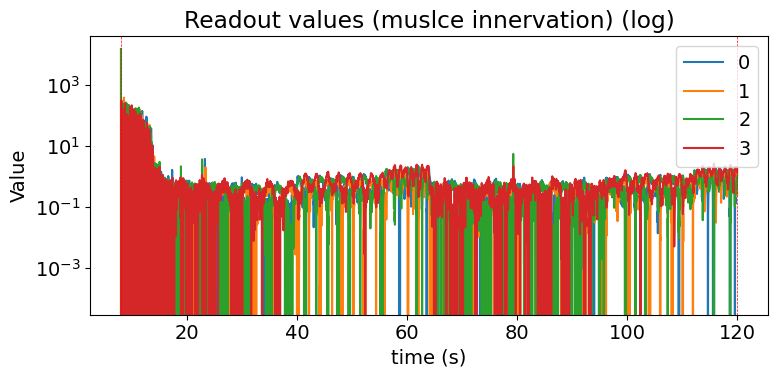

In [40]:
#readout neurons
exp.plotData (
    SNN_FORCE, key="readout", title="Readout values (muslce innervation) (log)",
    log=True, tlim=(4,None),
    selectIndices=[4,5,6,7],
    phaseName="FORCE open loop",
    fileName="readout_muscleValues(Humerus)_log.svg"
) #for control values
#plotData (SNN_FORCE, key="readout", title="Readout values (muslce innervation)", tlim=(4.2,None)) #for control values

In [41]:
w_rev = SNN_FORCE["new_w"].copy()
w_rev.reverse()

for i,w in enumerate(w_rev):
    if w != None:
        lastLearningIndex = len(w_rev)-i-1
        break

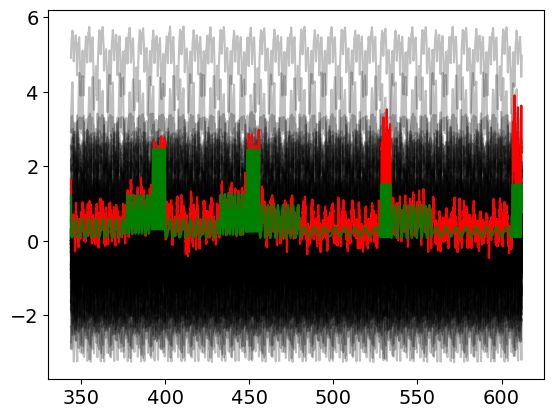

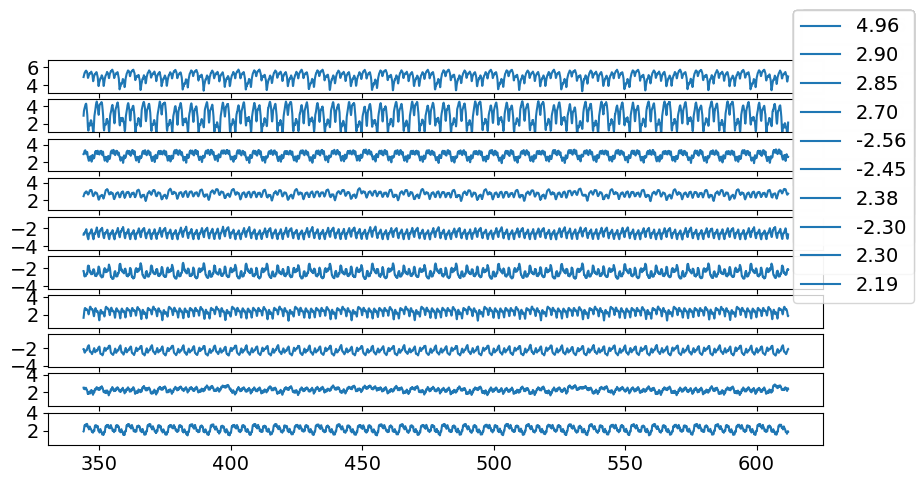

In [42]:

def expensivePlot1():
    #get final weights
    #lastLearningIndex = int((exp.phases[4]["t_start"]+exp.phases[4]["duration"])/exp.stepSize)-1
    finalWeights = np.array(SNN_FORCE["new_w"][lastLearningIndex]).transpose()

    monitorStates = np.array(SNN_FORCE["reservoir_state"][lastLearningIndex:])

    #apply weights for muscle m
    m = 7
    weightedMonitors = monitorStates*finalWeights[7]
    weightedMonitors = weightedMonitors.transpose()

    #sort monitors by magnitude (bs mean value)
    magnitudes = np.mean(np.abs(weightedMonitors),axis=1)
    prios = np.argsort(magnitudes)
    prios = prios[::-1] #reverse

    #overly plot
    N = int(exp.columns*0.75)
    p1 = weightedMonitors[prios[0]]
    total = np.zeros_like(p1)
    gt = np.array(exp.MuscleValues[lastLearningIndex:]).transpose()[m]
    ts = SNN_FORCE["time"][lastLearningIndex:]

    plt.figure()

    for figNr, i in enumerate(prios[:N]):
        plt.plot(ts,weightedMonitors[i],alpha = 0.25, color="black")
        total += weightedMonitors[i]

    plt.plot(ts, total, color="red")
    plt.plot(ts, gt, color="green")
    plt.savefig(exp.workingFolder+f'populations_waveAggregation_m{m}.svg')
    plt.show()

    #draw first N most important monitors
    N = 10
    yrange = (max(p1)-min(p1))*1.5
    nrows=N
    fig, axs = plt.subplots(
            nrows=nrows,
            ncols=1,
            sharey='row', sharex='all',
            figsize=(10,nrows*0.5),
            squeeze=False)

    for figNr, i in enumerate(prios[:N]):
        mean = np.mean(weightedMonitors[i])
        axs[figNr][0].plot(ts,weightedMonitors[i],label=f'{mean:.2f}')
        axs[figNr][0].set_ylim((mean-0.5*yrange,mean+0.5*yrange))

        #axs[0][0].set_title(f'Top {showBest} weighted monitor inputs ({exp.muscleNames[m]}, effective contribution sorted)')
        fig.legend()
        #fig.tight_layout()

    plt.savefig(exp.workingFolder+f'populations_top{N}_weightedSignals.svg')
    plt.show()

#expensivePlot1() #uncomment if oyu dont have time

In [43]:
#read and weight monitor states

for weights in SNN_FORCE["new_w"][::-1]:
    if weights != None:
        break
weights = np.array(weights).transpose()

#get reservoir monitor states during testing
i_start = int( exp.phases[5]["t_start"]/exp.stepSize )
i_end = int(( exp.phases[5]["t_start"]+exp.phases[5]["duration"])/exp.stepSize )
monitorStates = np.array(SNN_FORCE["reservoir_state"][i_start:i_end])

readoutStates = np.array([weights*monitorState for monitorState in monitorStates])

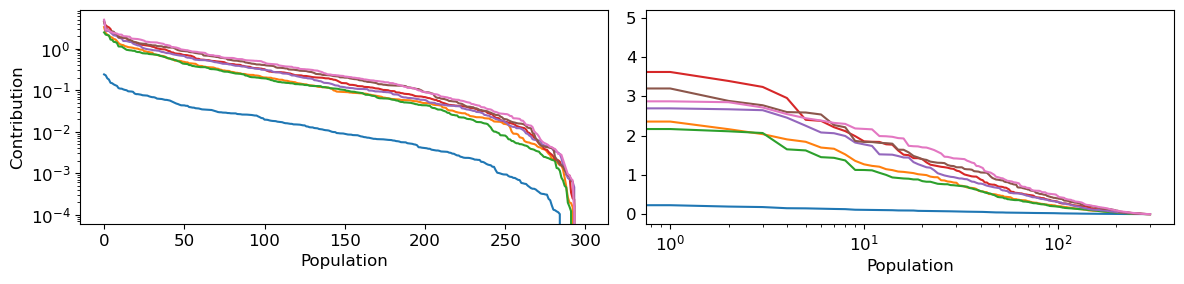

In [44]:
#darw weight contributions

selectIndices=[1,2,3,4,5,6,7]#[7]

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

fig_width = 6
fig_height = 3
nrows = 1
ncols=2
fig, axs = plt.subplots(
                nrows=nrows,
                ncols=ncols,
                #sharey='row', sharex='all',
                figsize=(fig_width*ncols,nrows*fig_height),
                squeeze=False)

for m in selectIndices:
    m_readouts = readoutStates[:,m]
    mean_readouts = np.mean(m_readouts,axis = 0)
    
    #sort by mean
    prios = np.argsort(np.abs(mean_readouts))
    

    sortedAbsMeans = np.abs(mean_readouts[prios[::-1]])
    sortedAbsMeans[sortedAbsMeans<10**-4]=0

    axs[0][0].plot(sortedAbsMeans)
    axs[0][1].plot(sortedAbsMeans)
#print(means)
#plt.yscale("log")
axs[0][0].set_yscale("log")
axs[0][1].set_xscale("log")

axs[0][0].set_xlabel("Population")
axs[0][1].set_xlabel("Population")
axs[0][0].set_ylabel("Contribution")
#axs[0][0].set_title("Mean population membrane potential distribution")
#axs[0][0].legend()
#axs[0][0].set_ylim(0,None)
fig.tight_layout()

plt.savefig(exp.workingFolder+f'weight_testing_distribution_sorted.svg')
plt.show()
    

## *Used for Figure 5.3*

Mean fig 0 = 3.290721217279487
Mean fig 1 = 2.358149009645934
Mean fig 2 = -2.1640832851247964
Mean fig 3 = 2.0379492411718165
Mean fig 4 = 1.9048454778864712
Mean fig 5 = -1.842924268550034
Mean fig 6 = 1.6961724855066256
Mean fig 7 = 1.6655297108484433
Mean fig 8 = -1.521371803495224
Mean fig 9 = -1.357221990685168
Muscle signal mean = 0.2981346045451267


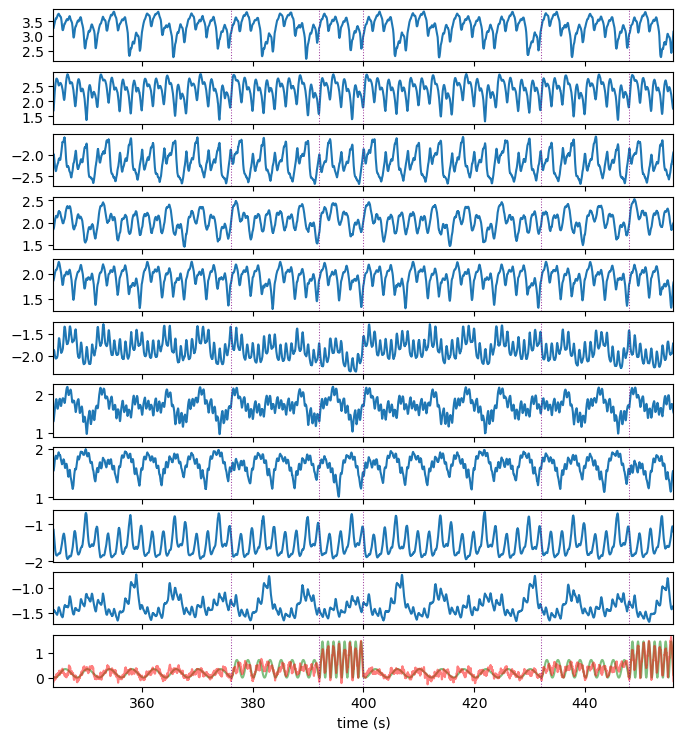

In [45]:
#Weightend monitor contributions while testing

m_i = 2

best = 10 #how many of the best

import matplotlib
matplotlib.rcParams.update({'font.size': 10})

fig_width = 8
fig_height = 0.8
nrows = best+1
ncols=1
fig, axs = plt.subplots(
                nrows=nrows,
                ncols=ncols,
                sharey='row', sharex='all',
                figsize=(fig_width*ncols,nrows*fig_height),
                squeeze=False,
                gridspec_kw = {'wspace':0, 'hspace':0.2})

m_readouts = readoutStates[:,m_i]
mean_readouts = np.mean(m_readouts,axis = 0)
    
#sort by mean
prios = np.argsort(np.abs(mean_readouts))
prios_rev = prios[::-1]

ts = SNN_FORCE["time"][i_start:i_end]
ylim=(-3,4)
for figNr, index in enumerate(prios_rev[:best]):
        
    axs[figNr][0].plot(ts,m_readouts[:,index],label=f'{mean_readouts[index]:.2f}')
    print(f'Mean fig {figNr} = {mean_readouts[index]}')
    #axs[figNr][0].set_ylim(ylim)
    #axs[figNr][0].hlines(y=0,xmin=ts[0],xmax=ts[-1],color = "black",alpha=0.5,linestyle="--")
    #axs[figNr][0].legend()
    
    #add scenario transitions
    for phase in exp.phases:
        axs[figNr][0].axvline(phase["t_start"], color = pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])

        if (phase["name"] in ["FORCE open loop","FORCE mixed","FORCE closed loop","FORCE testing"] ):  # -> GT with/without noise
            t_start=phase["t_start"]
            for section in self.subsections:
                duration = phase["periods"]/section["frequency"]
                t_end=t_start+duration

                if(phase["t_start"] != t_start):
                    axs[figNr][0].axvline(t_start, color = pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

                t_start = t_end #update temporal position
            if(phase["t_start"] != t_start):
                axs[figNr][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

        elif (phase["name"] == "FORCE interpolation"):

            t_start=phase["t_start"]
            for section in self.interpolateSubsections:
                duration = phase["periods"]/section["frequency"]
                t_end=t_start+duration
                if(phase["t_start"] != t_start):
                    axs[figNr][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

                t_start = t_end #update temporal position
            if(phase["t_start"] != t_start):
                axs[figNr][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

    axs[figNr][0].axvline(exp.phases[-1]["t_start"]+exp.phases[-1]["duration"], color =  pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])
    
    axs[figNr][0].set_xlim(exp.phases[5]["t_start"],exp.phases[5]["t_start"]+exp.phases[5]["duration"])

#draw Aggregation
m_readouts = readoutStates[:,m_i]
m_total = np.sum(m_readouts,axis=1)
print(f"Muscle signal mean = {np.mean(m_total)}")

axs[best][0].plot(ts,np.array(exp.MuscleValues)[i_start:i_end,m_i], color="green", alpha=0.5)
axs[best][0].plot(ts,m_total, color="red", alpha=0.5)

#add scenario transitions
for phase in exp.phases:
    axs[best][0].axvline(phase["t_start"], color = pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])

    if (phase["name"] in ["FORCE open loop","FORCE mixed","FORCE closed loop","FORCE testing"] ):  # -> GT with/without noise
        t_start=phase["t_start"]
        for section in self.subsections:
            duration = phase["periods"]/section["frequency"]
            t_end=t_start+duration

            if(phase["t_start"] != t_start):
                axs[best][0].axvline(t_start, color = pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

            t_start = t_end #update temporal position
        if(phase["t_start"] != t_start):
            axs[best][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

    elif (phase["name"] == "FORCE interpolation"):

        t_start=phase["t_start"]
        for section in self.interpolateSubsections:
            duration = phase["periods"]/section["frequency"]
            t_end=t_start+duration
            if(phase["t_start"] != t_start):
                axs[best][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

            t_start = t_end #update temporal position
        if(phase["t_start"] != t_start):
            axs[best][0].axvline(t_start, color =  pColor[1], linestyle=pStyle[1], linewidth=pWidth[1], alpha = alpha[1])

axs[best][0].axvline(exp.phases[-1]["t_start"]+exp.phases[-1]["duration"], color =  pColor[0], linestyle=pStyle[0], linewidth=pWidth[0], alpha = alpha[0])
axs[best][0].set_xlim(exp.phases[5]["t_start"],exp.phases[5]["t_start"]+exp.phases[5]["duration"])
    

#axs[0][0].set_yscale("log")
#axs[0][1].set_xscale("log")

axs[-1][0].set_xlabel("time (s)")
#axs[0][0].set_ylabel("Contribution")
#axs[0][0].set_title("Mean population membrane potential distribution")
#axs[0][0].legend()
#axs[0][0].set_ylim(0,None)
#fig.tight_layout()

plt.savefig(exp.workingFolder+f'top10weights_m={m_i}.svg')
plt.show()


In [47]:
#Weightend monitor contributions

def expensivePlot2():
    selectIndices=[7]

    T = len(SNN_FORCE["new_w"])
    M = 8#len(SNN_FORCE["new_w"][0][0])
    P = exp.columns #len(SNN_FORCE["new_w"][0])

    contributions = np.zeros((T,M,P)) # shape: T=timestemps, M=muscles, P=Populations 

    for t, weights in enumerate(SNN_FORCE["new_w"]):
        if(weights == None):
            continue
        monitorState = SNN_FORCE["reservoir_state"][t]
        for m, muscleWeights in enumerate(np.array(weights).transpose()):
            #print(f'Weight:\t\t{muscleWeights}')
            #print(f'monitorState:\t{monitorState}')
            contrib = monitorState*muscleWeights
            #print(f'-> contrib:\t{contrib}')
            contributions[t,m]=contrib

            if(sum(np.isnan(contrib))>0):
                print(f't={t} m={m}\t-> {contrib}')
            #print(contrib[-5])


    showBest = 10 #if we do not want to see all only show the most important ones

    fr = 300
    ts = SNN_FORCE["time"][fr:]
    #ylim = (-3,3)
    ylim = (None,None)
    lim = 5

    for m in range(M):
        if(not m in selectIndices):
            continue
        m_contrib = contributions[fr:,m]
        m_contrib[m_contrib>lim] = lim
        m_contrib[m_contrib<-lim] = lim

        #print(f'M {m} -> {m_contrib[-5]}')

        means = np.mean(m_contrib,axis=0)
        #print(means.shape)
        prios = np.argsort(np.abs(means))
        prios = prios[::-1] #reverse

        nrows = showBest
        fig, axs = plt.subplots(
                nrows=nrows,
                ncols=1,
                sharey='row', sharex='all',
                figsize=(8,nrows*0.5),
                squeeze=False)

        for figNr, p in enumerate(prios[:showBest]):
            p_contrib = m_contrib[:,p]

            #plt.figure(figsize=(10,0.5))
            mean = np.mean(p_contrib)
            axs[figNr][0].plot(ts,p_contrib,label=f'{mean:.2f}')
            axs[figNr][0].set_ylim(ylim)

        axs[0][0].set_title(f'Top {showBest} weighted monitor inputs ({exp.muscleNames[m]}, effective contribution sorted)')
        #fig.legend()
        #fig.tight_layout()
        plt.show()
        
#expensivePlot2() #uncomment if you dont have time
          

In [48]:
#ALL MONITOR POPULATIONS

def expensivePlot3():
    #TODO: sort my mean

    ts = SNN_FORCE["time"]
    readouts = np.array(SNN_FORCE["reservoir_state"]).transpose() # shape: P=Populations, T=Timestamps

    nrows = P
    fig, axs = plt.subplots(
            nrows=nrows,
            ncols=1,
            sharey='row', sharex='all',
            figsize=(10,nrows*0.5),
            squeeze=False)

    ylim = (0,40000)

    for p in range(P):
        readout = readouts[p]
        mean = np.mean(readout)
        figNr = p
        axs[figNr][0].plot(ts,readout,label=f'{mean:.2f}')
        #axs[figNr][0].set_title(f'{mean:.2f}')
        #axs[figNr][0].set_ylim(ylim)

    axs[0][0].set_title(f'All montor population values (not weighted or sorted)')
    #fig.legend()
    plt.savefig(exp.workingFolder+f'populations_monitors_all.svg')

    plt.show()
    
    
    plt.figure()

    for p in range(P):
        readout = readouts[p]
        mean = np.mean(readout)
        plt.plot(ts,readout,alpha=0.25,color="black")

    plt.title(f'All montor population values (not weighted or sorted)')
    plt.savefig(exp.workingFolder+f'populations_moniors_all_overlay.svg')

    plt.show()
    
#expensivePlot3() #uncomment if you have time

### Weight contribution

### Inspect specific polulation output

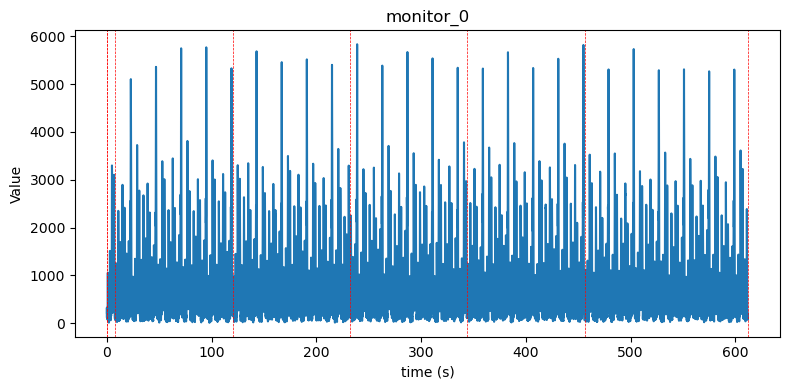

In [49]:
#view specific population output
pop_index = 0

d = np.array(SNN_FORCE["reservoir_state"]).transpose()
key = "monitor_"+str(pop_index) #select population
SNN_FORCE[key] = d[pop_index]

#reservoir monitors
exp.plotData(SNN_FORCE, key=key,tlim=(0,None),legend=False,
            fileName=f"population_{pop_index}_signal.svg") #for control values


stepLim[3250, 3350]


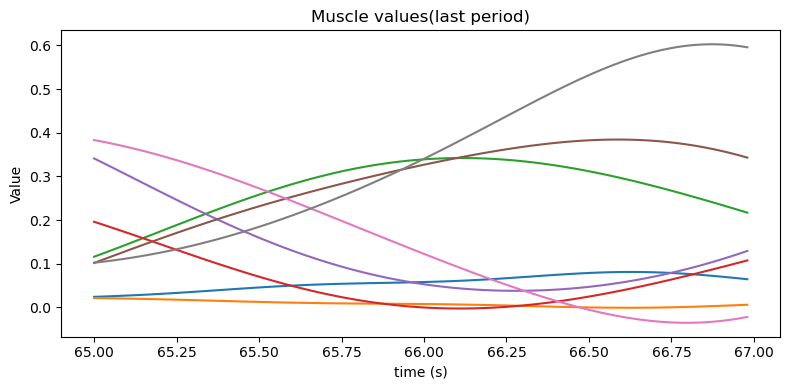

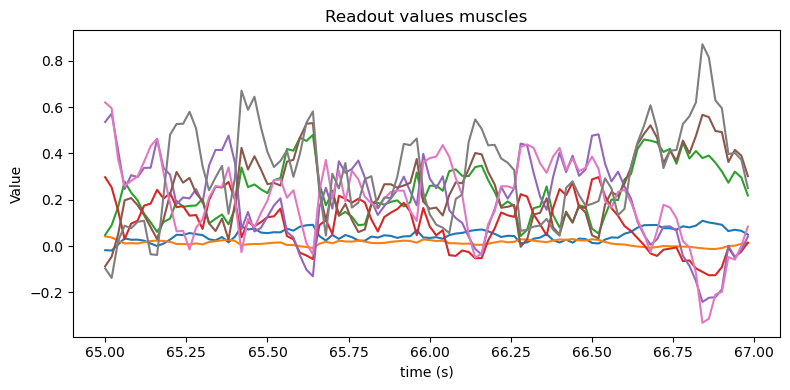

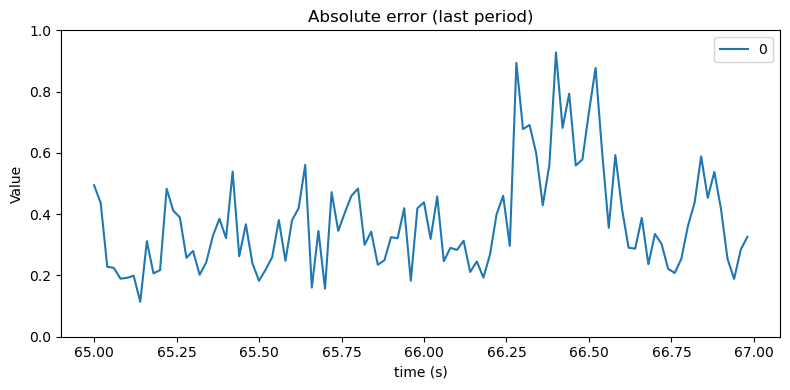

In [50]:
exp.plotData( exp.MuscleValues,
         #valueDict = {"Foot1":[],"Foot2":[],"Radius1":[],"Radius2":[],"Humerus1":[],"Humerus2":[],"Humerus3":[], "Humerus4":[]},
         title = "Muscle values(last period)", tlim=(65,67), legend=False,
        fileName=f"lastperiod_GT_muscles.svg"
            )

exp.plotData( SNN_FORCE, key="readout",
         #valueDict = {"Foot1":[],"Foot2":[],"Radius1":[],"Radius2":[],"Humerus1":[],"Humerus2":[],"Humerus3":[], "Humerus4":[]},
         title = "Readout values muscles", legend=False, log=False, tlim=(65,67),
            fileName=f"lastperiod_readout_muscles.svg")

exp.plotData(SNN_FORCE, key="error_abs", title="Absolute error (last period)", tlim=(65,67), ylim=(0,1), log=False,
            fileName=f"lastperiod_error.svg"
            )
